In [210]:
from root_pandas import read_root
import numpy as np
from ROOT import TFile,TTree
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

# Math Functions

In [2]:
def expexp(x,*param):
    lamb, x0, N ,y0 = param 
    return N*np.exp(np.exp(-lamb*(x - x0))) + y0 

def Sexp(x,*param):
    lamb0, x0, N0 ,y0,lamb1, x1, N1 ,y1 = param 
    return (N0*np.exp(-lamb0*(x - x0)) + y0) + (N1*np.exp(-lamb1*(x - x1)) + y1 )

def exp2(x,*param):
    lamb, x0, N ,y0 = param 
    return N*np.exp(-lamb*(x - x0)) + y0 
def exp(x,*param):
    lamb, x0, N = param 
    return N*np.exp(-lamb*(x - x0))

def poly1(x,*param):
    return param[0] + param[1]*x

def poly2(x,*param):
    return param[0] + param[1]*x + param[2]*x*x

def chi2(x,sig,func,parm):
    chi = 0
    for xi,si in zip(x,sig):
        chi+= ((func(x,*parm)-xi)**2)/(si)**2
    return chi

# Tasks

In [62]:
varSim    = "Cluster"
Path      = '/home/jcordero/CMS/BRIL/data/'+varSim+'/'
figPath   = '/home/jcordero/CMS/BRIL/figs/'+varSim+'/'
x, y, z   = [],[],[]
phi,theta = [],[]
merge     = []

In [64]:
PU   = ['1','2','30','50','75','100','140']
data = {}
for pu in PU:
    fileName = Path+varSim+'_'+pu+'.0_00.root'
    treeName = varSim.lower()+'_tree'
    
    data[pu] = read_root(fileName,treeName)

In [65]:
xP, yP, zP  = {},{},{}
phiP, thetaP, mergeP, rP = {},{},{},{}
for pu in PU:
    xP[pu]      = np.array(data[pu].CluX)
    yP[pu]      = np.array(data[pu].CluY)
    zP[pu]      = np.array(data[pu].CluZ)
    phiP[pu]    = np.array(data[pu].CluPhi)
    thetaP[pu]  = np.array(data[pu].CluTheta)
    mergeP[pu]  = np.array(data[pu].CluMerge)
    rP[pu]      = np.sqrt(xP[pu]**2 + yP[pu]**2)    

# Geometrical Filters

In [66]:
rMaskRange = {
                1:[6.5,9.7],
                2:[10.9,13.7],
                3:[14.5,17.3],
                4:[18.4,20.9],
                5:[21.9,25.3],
                }

zMaskRange = {
                1:[174,176],
                2:[200,202],
                3:[230,232],
                4:[264,266],
                }

zMaskRangeInner = {
                    1:{
                        1:[174  ,174.5],
                        2:[174.5,175  ],
                        3:[175  ,175.5],
                        4:[175.5,176 ],
                    },
                    2:{
                        1:[200  ,200.5],
                        2:[200.5,201  ],
                        3:[201  ,201.5],
                        4:[202.5,203  ],
                    },
                    3:{
                        1:[230  ,230.5],
                        2:[230.5,230.7],
                        3:[231.7,231.2],
                        4:[231.2,231.6],
                    },
                    4:{
                        1:[264  ,264.5],
                        2:[264.5,265  ],
                        3:[265  ,265.5],
                        4:[265.5,266   ],
                    },
                    }
    
NRing = {
        1:10,
        2:14,
        3:18,
        4:22,
        5:24
        }    

In [11]:
Disk      = {}
InnerDisk = {}
Ring      = {}


for pu in PU:    
    Disk[pu]      = {}
    InnerDisk[pu] = {}
    Ring[pu]      = {}
    for zi in zMaskRange:
        PosD = np.logical_and( zP[pu] >  zMaskRange[zi][0] , zP[pu] <  zMaskRange[zi][1])
        NegD = np.logical_and( zP[pu] < -zMaskRange[zi][0] , zP[pu] > -zMaskRange[zi][1])
        
        Disk[pu][zi]      = np.logical_or(PosD,NegD) 
        InnerDisk[pu][zi] = {}
        for inzi in zMaskRangeInner[zi]:
            InnerPosD = np.logical_and( zP[pu] >  zMaskRangeInner[zi][inzi][0] , zP[pu] <  zMaskRangeInner[zi][inzi][1])
            InnerNegD = np.logical_and( zP[pu] < -zMaskRangeInner[zi][inzi][0] , zP[pu] > -zMaskRangeInner[zi][inzi][1])
            InnerNegD = InnerPosD 
            InnerDisk[pu][zi][inzi] = np.logical_or(InnerPosD, InnerNegD)

    for ri in rMaskRange:
        Ring[pu][ri] = np.logical_and( rP[pu] > rMaskRange[ri][0] , rP[pu] < rMaskRange[ri][1])
        

In [104]:
mask_nonOverlap = {}  
for pu in PU:
    mask_nonOverlap[pu] = Ring[pu][1]
    for ri in range(2,len(Ring[pu]) + 1):
        mask_nonOverlap[pu] = np.logical_or(mask_nonOverlap[pu],Ring[pu][ri])

# --------------------------------

# Clusters per Ring per Disk

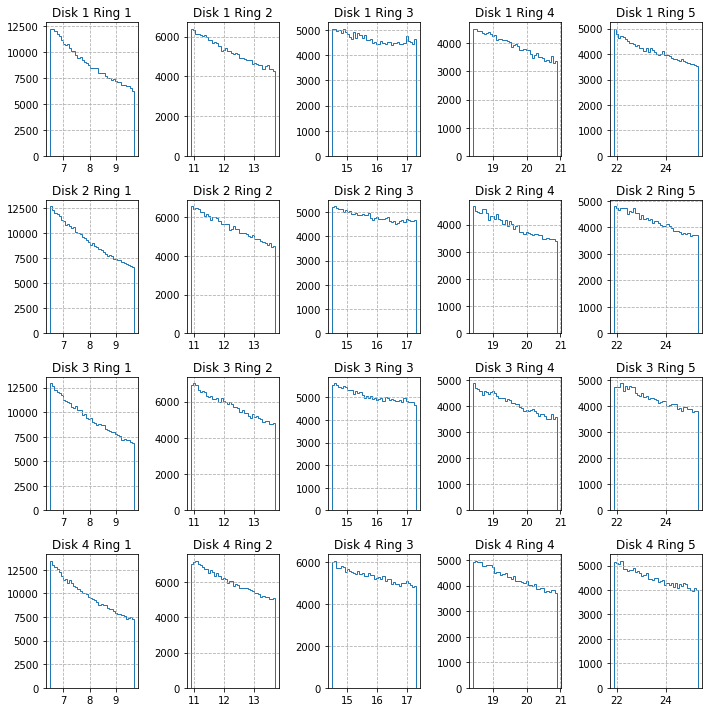

In [72]:
pu = '140'
mask = []
n = 0
#P0 = [1,0,2000,0]
P0 = [1,0,1000]

fig = plt.figure(figsize=(10,10))
for di in Disk[pu]:
    for ri in Ring[pu]:
        mask = np.logical_and(Disk[pu][di],Ring[pu][ri])
        n+=1
        plt.subplot(4,5,n)
        hist = plt.hist(
                        rP[pu][mask],
                        bins = 40,
                        histtype = 'step',
                        )
        plt.title('Disk '+str(di)+' Ring '+str(ri))
        plt.grid(linestyle='--')
        
        X,Y = hist[1],hist[0]
        xc = (X[:-1]+X[1:])/2
        
        #func = exp
        #func = poly2
        #parm = curve_fit(func,xc,Y,p0=P0)
        #plt.plot(xc,func(xc,*parm[0]))
        
        sig = []
        #for i in range(len(parm[1])):
        #    sig.append(parm[1][i][i])
        #print(chi2(xc,sig,func,parm))
plt.tight_layout()
fig.savefig(figPath+'Radial/Disk_Ring.png')

        

# Per Disk Clusters, not Normalized

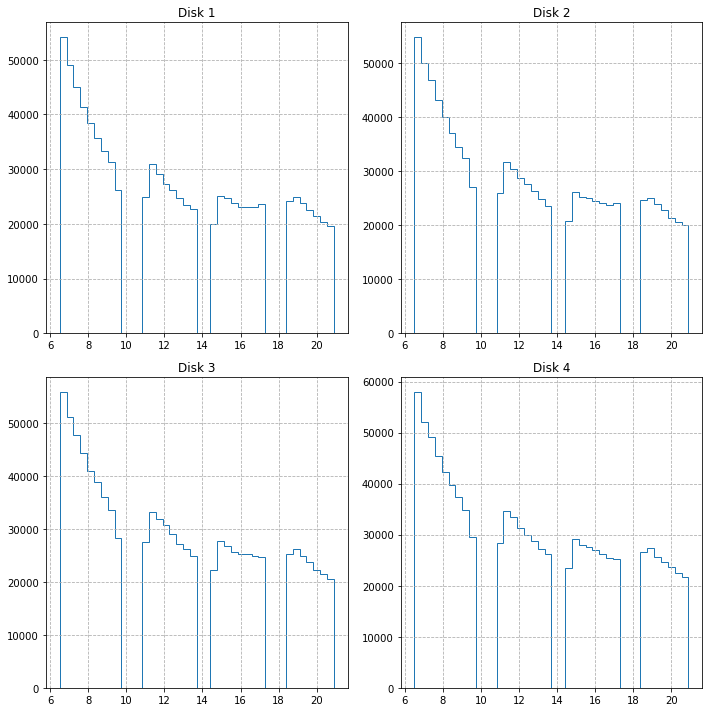

In [105]:
mask = []
n = 0
#P0 = [1,0,2000,0]
P0 = [1,0,1000]

fig = plt.figure(figsize=(10,10))
for di in Disk[pu]:
    mask = Disk[pu][di]
    masking = Ring[pu][1]
    for ri in range(2,len(Ring[pu])):
        masking = np.logical_or(masking,Ring[pu][ri])
    mask = np.logical_and(mask,masking)
    
    n+=1
    plt.subplot(2,2,n)
    hist = plt.hist(
                    rP[pu][mask],
                    bins = 40,
                    histtype = 'step',
                    )
    plt.title('Disk '+str(di))
    plt.grid(linestyle='--')

    X,Y = hist[1],hist[0]
    xc = (X[:-1]+X[1:])/2

    #func = exp
    func = poly2
    #parm = curve_fit(func,xc,Y,p0=P0)
    #plt.plot(xc,func(xc,*parm[0]))

    sig = []
    #for i in range(len(parm[1])):
    #    sig.append(parm[1][i][i])
    #print(chi2(xc,sig,func,parm))
fig.savefig(figPath+'Radial/perDisk.png')   
plt.tight_layout()

----------------ZvsR geometrical-----------


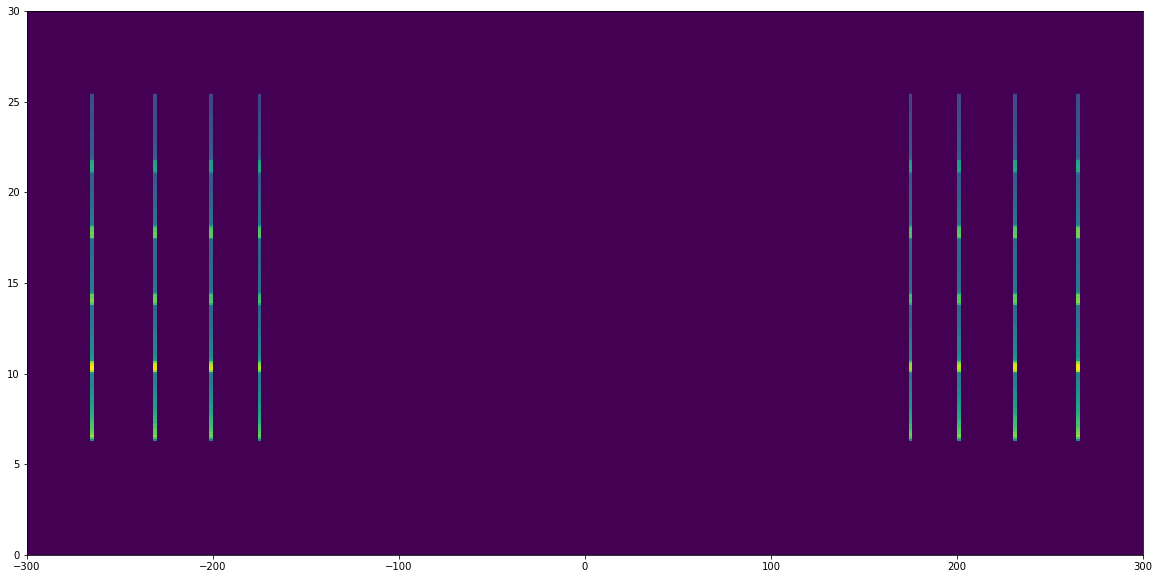

----------------Pos or Neg geometry-----------


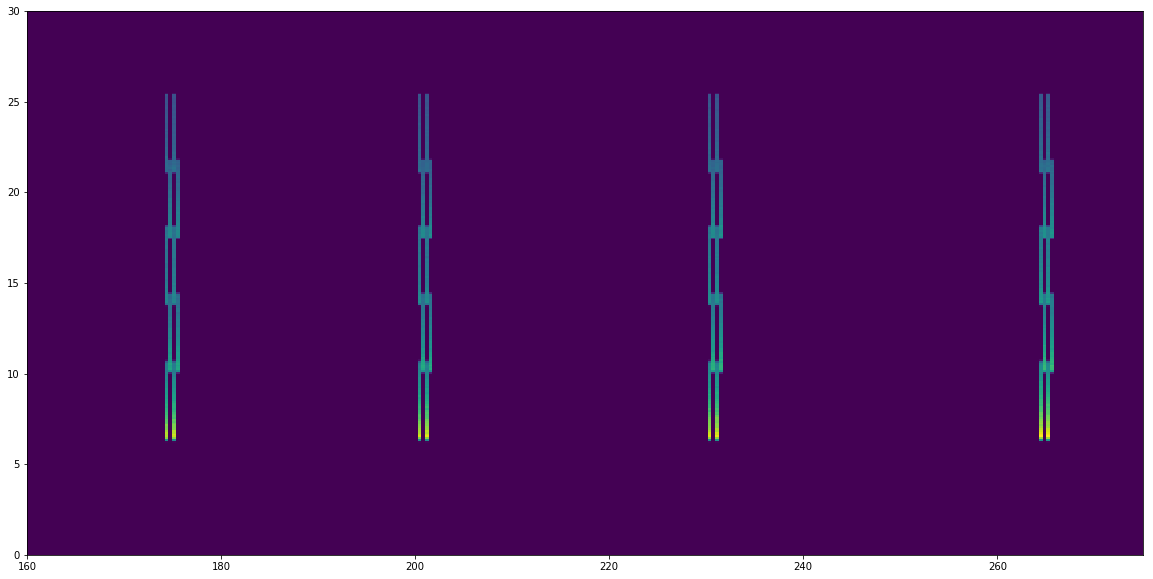

----------------Single Disk geometry-----------


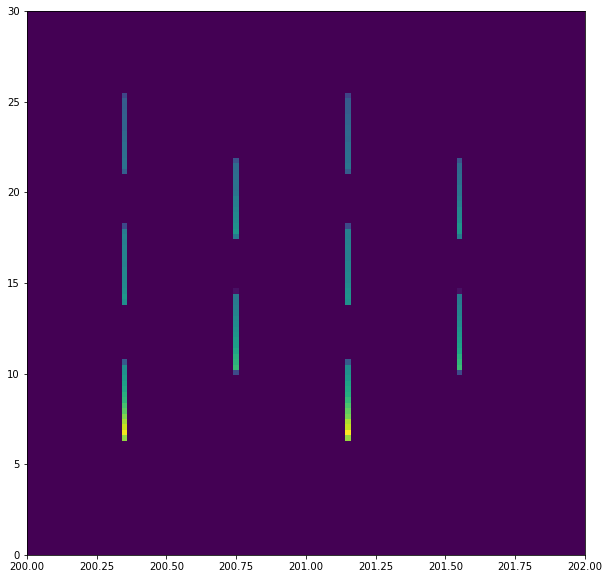

In [74]:
pu = '140'
d = 2
#mask= np.logical_or(InnerDisk[pu][d][1],InnerDisk[pu][d][2])
mask= Disk[pu][d]

print('----------------ZvsR geometrical-----------')
fig = plt.figure(figsize=(20,10))
plt.hist2d(zP[pu],rP[pu],
         bins = 300,
        range = [[-300,300],[0,30]]
        );
plt.show()
fig.savefig(figPath+'ZvsR'+'_PU'+pu+'.png')

print('----------------Pos or Neg geometry-----------')
fig = plt.figure(figsize=(20,10))
plt.hist2d(zP[pu],rP[pu],
         bins = 300,
        range = [[160,275],[0,30]]
        );
plt.show()
fig.savefig(figPath+'ZvsR'+'_PU'+pu+'_Pos.png')

print('----------------Single Disk geometry-----------')
fig = plt.figure(figsize=(10,10))
plt.hist2d(zP[pu][mask],rP[pu][mask],
         bins = 100,
        range = [zMaskRange[d],[0,30]]
        );
plt.show()
fig.savefig(figPath+'ZvsR'+'_PU'+pu+'_D'+str(d)+'.png')


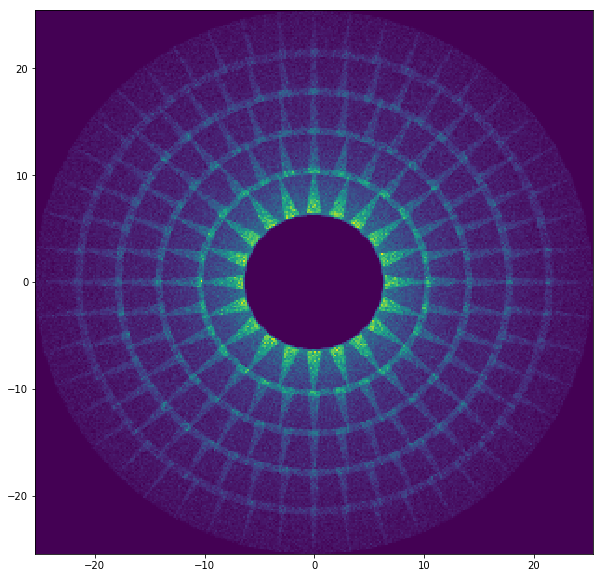

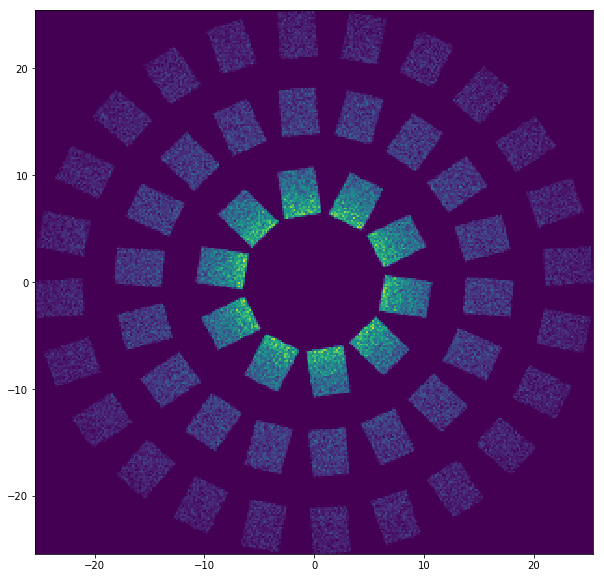

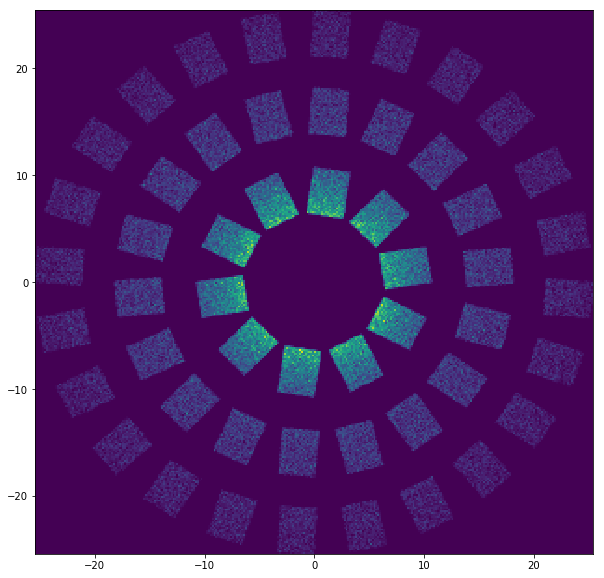

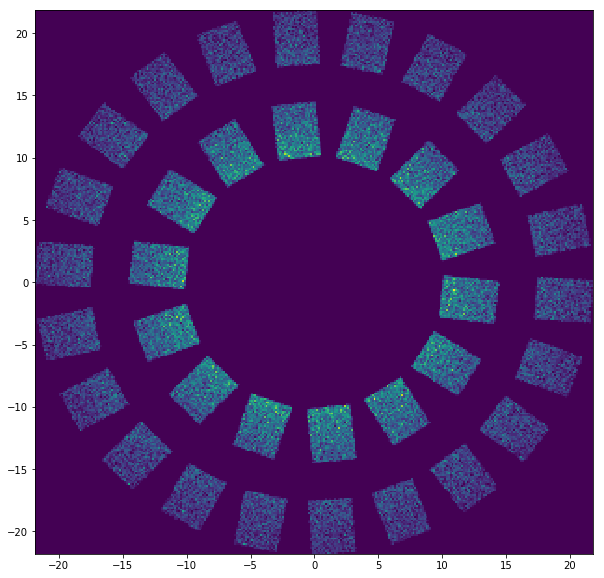

In [75]:
pu = '140'
d  = 2
di = 1

mask= Disk[pu][d]
fig = plt.figure(figsize=(10,10))
plt.hist2d(xP[pu][mask],yP[pu][mask],bins = 300);
fig.savefig(figPath+'XvsY'+'_PU'+pu+'_D'+str(d)+'.png')

#mask= np.logical_or(InnerDisk[pu][d][1],InnerDisk[pu][d][2])
mask= InnerDisk[pu][d][di]
fig = plt.figure(figsize=(10,10))
plt.hist2d(xP[pu][mask],yP[pu][mask],bins = 300);
fig.savefig(figPath+'XvsY'+'_PU'+pu+'_D'+str(d)+'_ID_'+str(di)+'.png')

di = 3
mask= InnerDisk[pu][d][di]
fig = plt.figure(figsize=(10,10))
plt.hist2d(xP[pu][mask],yP[pu][mask],bins = 300);
fig.savefig(figPath+'XvsY'+'_PU'+pu+'_D'+str(d)+'_ID_'+str(di)+'.png')

di = 2
mask= InnerDisk[pu][d][di]
fig = plt.figure(figsize=(10,10))
plt.hist2d(xP[pu][mask],yP[pu][mask],bins = 300);
fig.savefig(figPath+'XvsY'+'_PU'+pu+'_D'+str(d)+'_ID_'+str(di)+'.png')

------------Unfilterd R projection------------


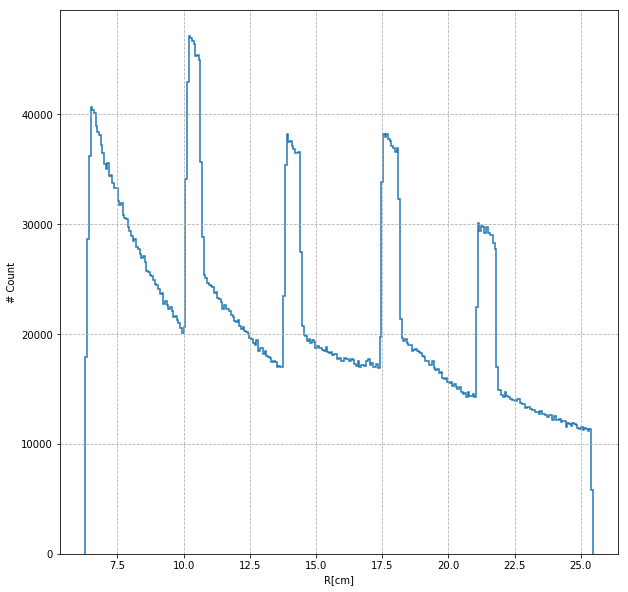

------------Filtered R projection------------


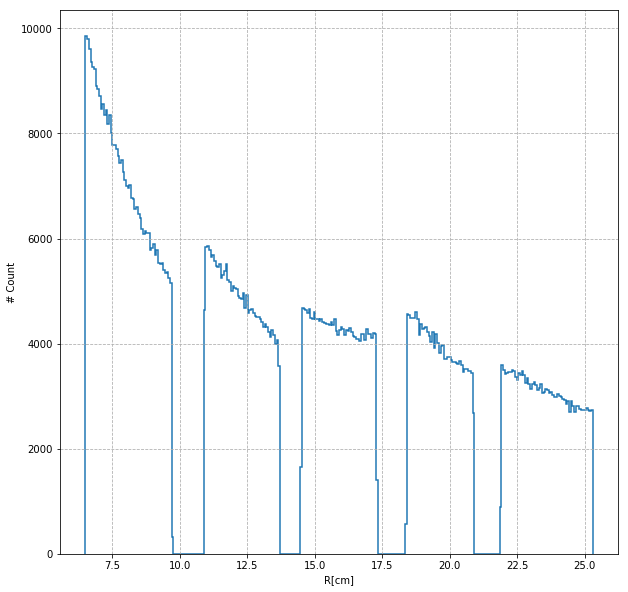

------------Filtered Normalized R projection------------


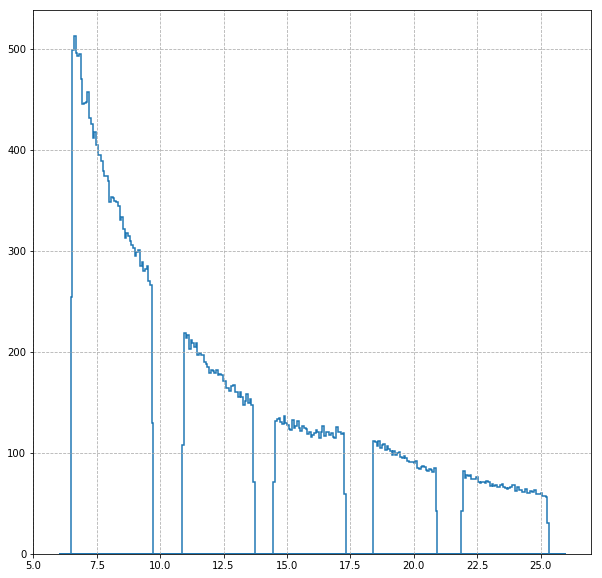

In [76]:

pu   = '140'
d    = 2
bins = 300
###########################################################
print('------------Unfilterd R projection------------')
fig = plt.figure(figsize=(10,10))
plt.hist(rP[pu],
        histtype = 'step',
        bins = bins,
        linewidth = 1.5,
        )
plt.ylabel('# Count')
plt.xlabel('R[cm]')
plt.grid(linestyle='--')
plt.show()
fig.savefig(figPath+'Radial/Radial.png')
###########################################################
print('------------Filtered R projection------------')
mask    = Disk[pu][d]
masking = Ring[pu][1]
for ri in range(2,len(Ring[pu])+1):
    masking = np.logical_or(masking,Ring[pu][ri])
mask = np.logical_and(mask,masking)

fig = plt.figure(figsize=(10,10))
plt.hist(rP[pu][mask],
        histtype = 'step',
        bins = bins,
        linewidth = 1.5,
        )
plt.ylabel('# Count')
plt.xlabel('R[cm]')
plt.grid(linestyle='--')
plt.show()
fig.savefig(figPath+'Radial/Radial_nonOverlap.png')
###########################################################
print('------------Filtered Normalized R projection------------')
d,din = 1,2
R = []

fig = plt.figure(figsize=(10,10))
for di in [1,2]:#InnerDisk:
    Mask    = np.logical_or(InnerDisk[pu][d][di],InnerDisk[pu][d][di+2])
    masking = Ring[pu][1]
    
    for ri in range(2,len(Ring[pu])+1):
        masking = np.logical_or(masking,Ring[pu][ri])
    Mask = np.logical_and(Mask,masking)
    
    for ri in Ring[pu]:
        mask = Ring[pu][ri]
        mask = np.logical_and(mask,Mask)
        
        h = plt.hist(rP[pu][mask],
                histtype  = 'step',
                weights   = [1/NRing[ri] for _ in rP[pu][mask]],
                range     = [6,26],
                bins      = bins,
                color     = 'C0',
                linewidth = '1.5',
                )
        R.append(h)
plt.grid(linestyle='--')
plt.show()
fig.savefig(figPath+'Radial/Radial_nonOverlap_perModule.png')   
    






# ---------------------- TEST ------------------------

In [281]:
exp2(xc,*(1,1,1,1))

array([1.00341349, 1.00238152, 1.00166153, 1.00115921, 1.00080876,
       1.00056425, 1.00039367, 1.00027465, 1.00019162, 1.00013369,
       1.00009327, 1.00006507, 1.0000454 , 1.00003167, 1.0000221 ,
       1.00001542, 1.00001076, 1.0000075 , 1.00000524, 1.00000365,
       1.00000255, 1.00000178, 1.00000124, 1.00000087, 1.0000006 ,
       1.00000042, 1.00000029, 1.00000021, 1.00000014, 1.0000001 ,
       1.00000007, 1.00000005, 1.00000003, 1.00000002, 1.00000002,
       1.00000001, 1.00000001, 1.00000001, 1.        , 1.        ])

In [285]:
def CHI2(*arg,DATA,Temp):
    Model = Temp(arg)
    DATA[DATA==0] = 1
    SIGMA_2 = (1/DATA + 1/Model)**(-1)
    return np.sum((Model-DATA)**2/SIGMA_2)

In [286]:
Temp  = lambda arg: exp2(xc,*arg)
model = lambda x0 : CHI2(DATA=Data,Temp=Temp,*x0)

In [287]:
print(Temp(ar))
#Temp(ar)
#D[mask]
print(len(D),len(mask))

[1.00341349 1.00238152 1.00166153 1.00115921 1.00080876 1.00056425
 1.00039367 1.00027465 1.00019162 1.00013369 1.00009327 1.00006507
 1.0000454  1.00003167 1.0000221  1.00001542 1.00001076 1.0000075
 1.00000524 1.00000365 1.00000255 1.00000178 1.00000124 1.00000087
 1.0000006  1.00000042 1.00000029 1.00000021 1.00000014 1.0000001
 1.00000007 1.00000005 1.00000003 1.00000002 1.00000002 1.00000001
 1.00000001 1.00000001 1.         1.        ]
200 6594586


# --------------------------------------------------

# Decay Rate of radial distribution

In [304]:
def R_decay(pu,funcName='exp2'):
    '''
    exp2 : lamb, x0, N ,y0 = param 
    exp  : lamb, x0, N     = param 
    poly2: a, b, c         = param
    ''';
    
    P0      = {
            'exp2':{ 
                        '0':[0.5,6,  10,0],
                        '1':[0.5,6,  20,0],
                        '2':[0.5,6,  30,0],
                       '10':[0.5,6, 100,0],
                       '20':[0.5,6, 200,0],
                       '30':[0.5,6, 300,0],
                       '50':[0.5,6, 500,0],
                       '75':[0.5,6, 800,0],
                      '100':[0.5,6,1000,0],
                      '140':[0.5,6,1400,0],
                      '175':[0.5,6,1700,0],
                      '200':[0.5,6,2000,0],
                    },
            'exp' :{
                        '0':[0.5,6,  10],
                        '1':[0.5,6,  20],
                        '2':[0.5,6,  30],
                       '10':[0.5,6, 100],
                       '20':[0.5,6, 200],
                       '30':[0.5,6, 300],
                       '50':[0.5,6, 500],
                       '75':[0.5,6, 800],
                      '100':[0.5,6,1000],
                      '140':[0.5,6,1400],
                      '175':[0.5,6,1700],
                      '200':[0.5,6,2000],
                    },
         }
    Bound   = {
            'exp' :((-np.inf,   0,      0),
                    (      0, 100, np.inf)),
            'exp2' :((   0, -100,      0,      0),
                     (  10,  100, np.inf, np.inf)),
            }
    Bounded = {
                'exp' :((-np.inf, 0),(   0, 100),( 0,np.inf) ),
                'exp2':((      0,10),(-100, 100),( 0,np.inf),(0,np.inf))
                }
    func    = {
            'exp' :exp,
            'exp2':exp2,
            }
    
    lambs = []
    n     = 0
    
    fig = plt.figure(figsize=(8,18))
    for di in Disk[pu]:
        R,wei = [],[]

        # Select Disk 
        mask    = [False for _ in zP[pu]]
        masking = [False for _ in zP[pu]]    

        n+=1
        plt.subplot(4,1,n)
        # Make the Ring Filter and set the weight normalization 
        for ri in Ring[pu]:
            mask = Disk[pu][di]
            mask = np.logical_and(mask,Ring[pu][ri])
            R   += list(rP[pu][mask])
            wei += [1/NRing[ri] for _ in rP[pu][mask]]
        

        h = np.histogram(
                        R,
                        weights = wei,
                        range   = [6,26],
                        bins    = 200,    
                        )    
        Data = h[0]
        mask = (Data!=0)


        xc = (h[1][:-1]+h[1][1:])/2
        plt.plot(xc[mask],
                 Data[mask])
            
        ###############################################
        Temp  = lambda arg: func[funcName](xc[mask],*arg)
        model = lambda x0 : CHI2(DATA=Data[mask], Temp=Temp, *x0)
        
        fitResult = minimize(model,
                             x0     = P0[funcName][pu],
                             method = 'L-BFGS-B',
                             bounds = Bounded[funcName]
                            )
        ###############################################
        curveFit = curve_fit(func[funcName], xc[mask], Data[mask],
                         p0     = P0[funcName][pu],
                         bounds = Bound[funcName],
                        )
        lamb,dlamb = curveFit[0][0], curveFit[1][0][0]
        ###############################################
        #parm = curveFit[0]
        parm = fitResult.x

        plt.plot(xc[mask],
                 func[funcName](xc[mask],*parm),
                 '-k')
        ax = plt.gca()
        
        # Set legend label and position
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        
        lenPosy = ylim[0]+(ylim[1]-ylim[0])*0.6
        lenPosx = xlim[0]+(xlim[1]-xlim[0])*0.6
        
        plt.text(lenPosx,lenPosy,
                 r'$\lambda$_'+'D'+str(di)+'= '+str(round(lamb,3))+'+-'+str(round(dlamb,5))+'\n',
                 bbox=dict(facecolor = 'white')
                )    
        plt.title('Disk '+str(di))
        plt.ylabel('# Counts')
        plt.xlabel('R[cm]')
        plt.grid(linestyle='--')
        
        plt.tight_layout()
        lambs.append(parm[0])
    fig.savefig(figPath+'Radial/Disks_radial_'+pu+'.png')
    return lambs, Data, xc, curveFit, fitResult

-------1--------
-------2--------
-------30--------
-------50--------
-------75--------
-------100--------
-------140--------


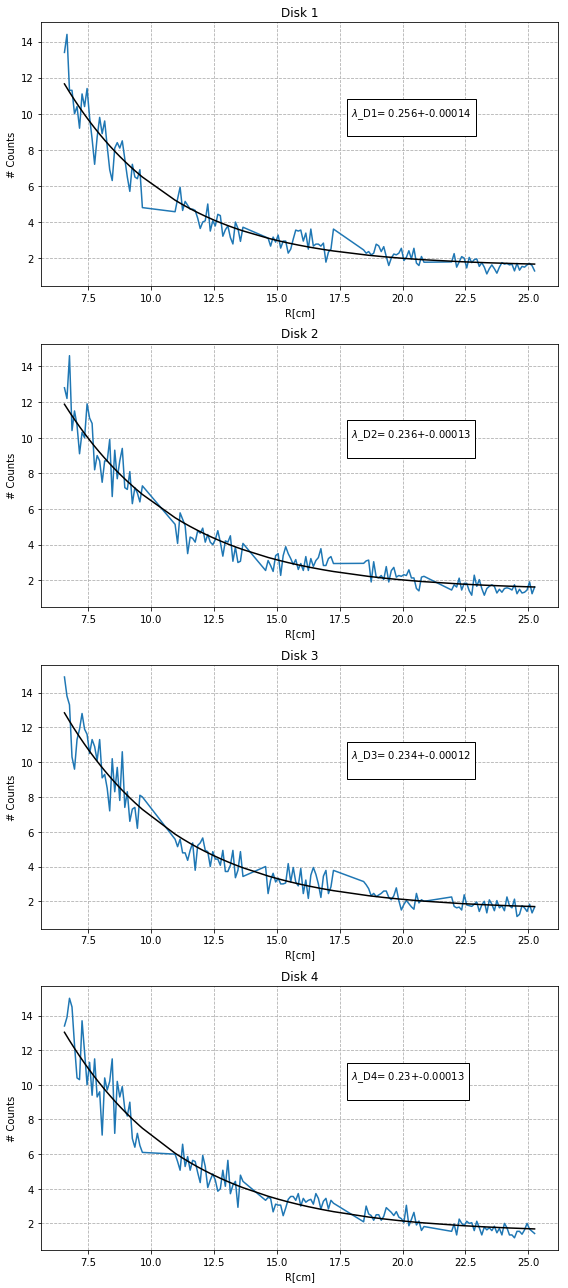

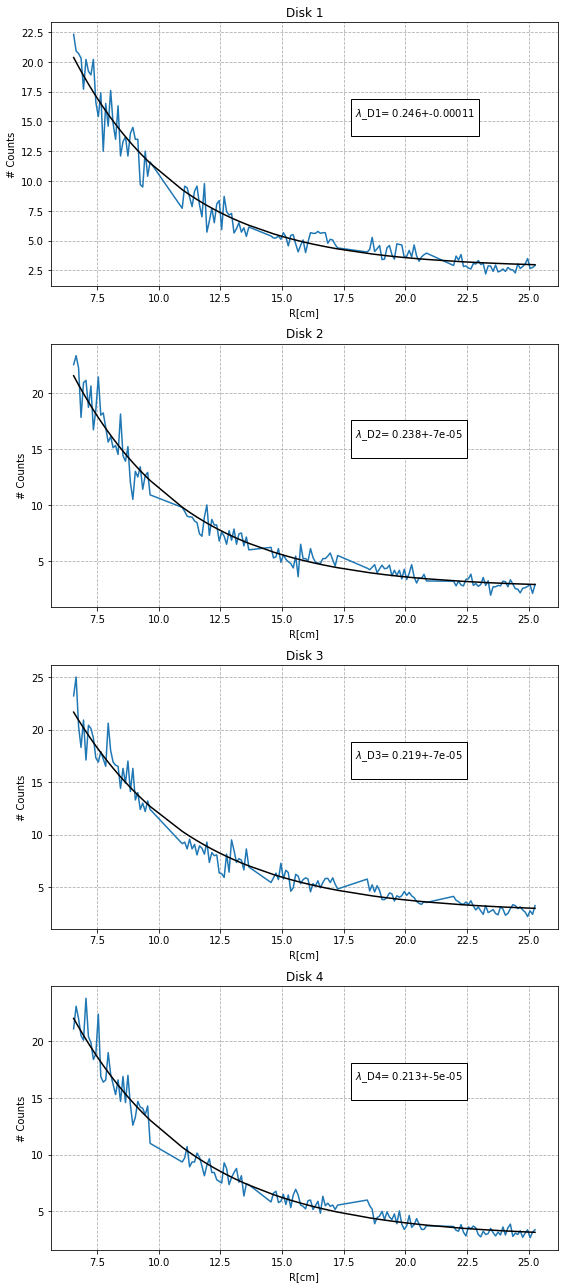

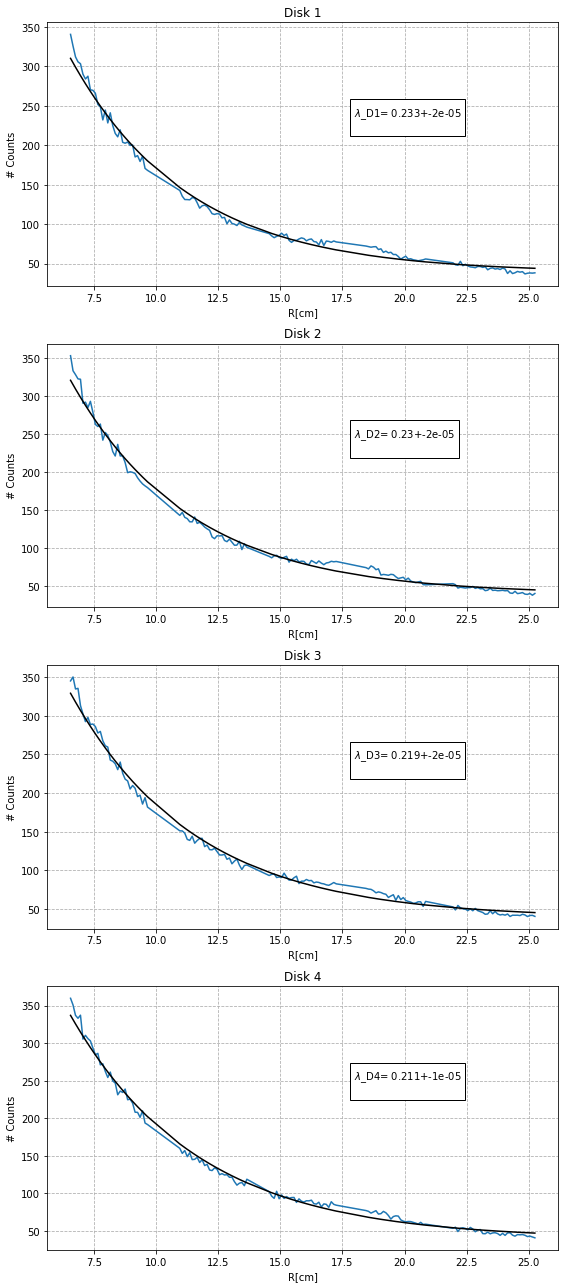

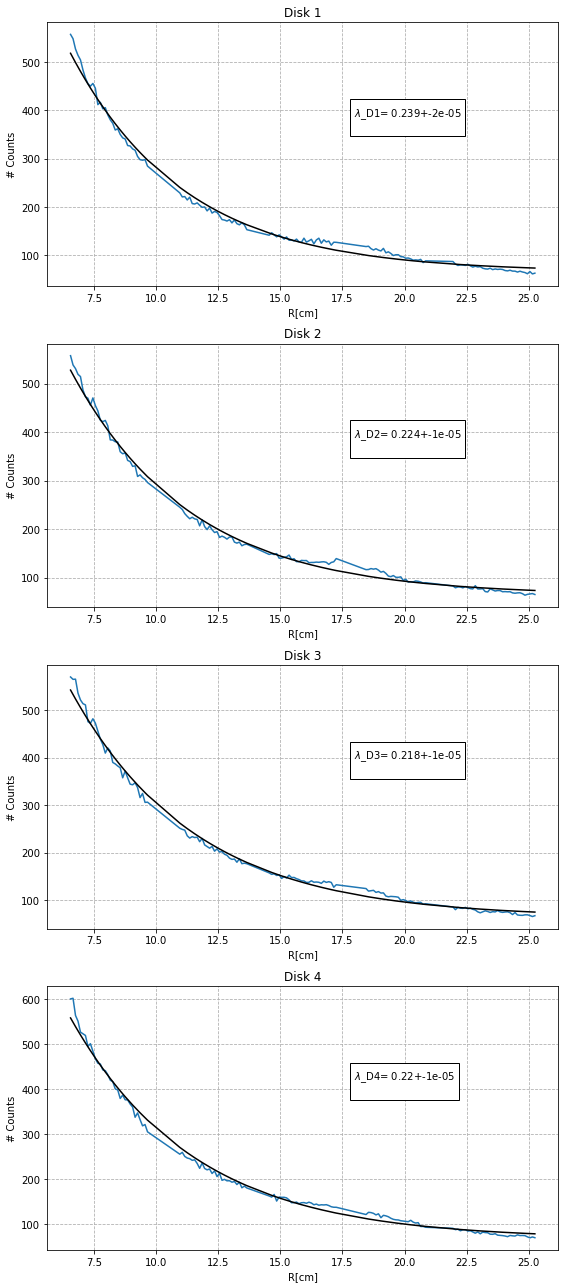

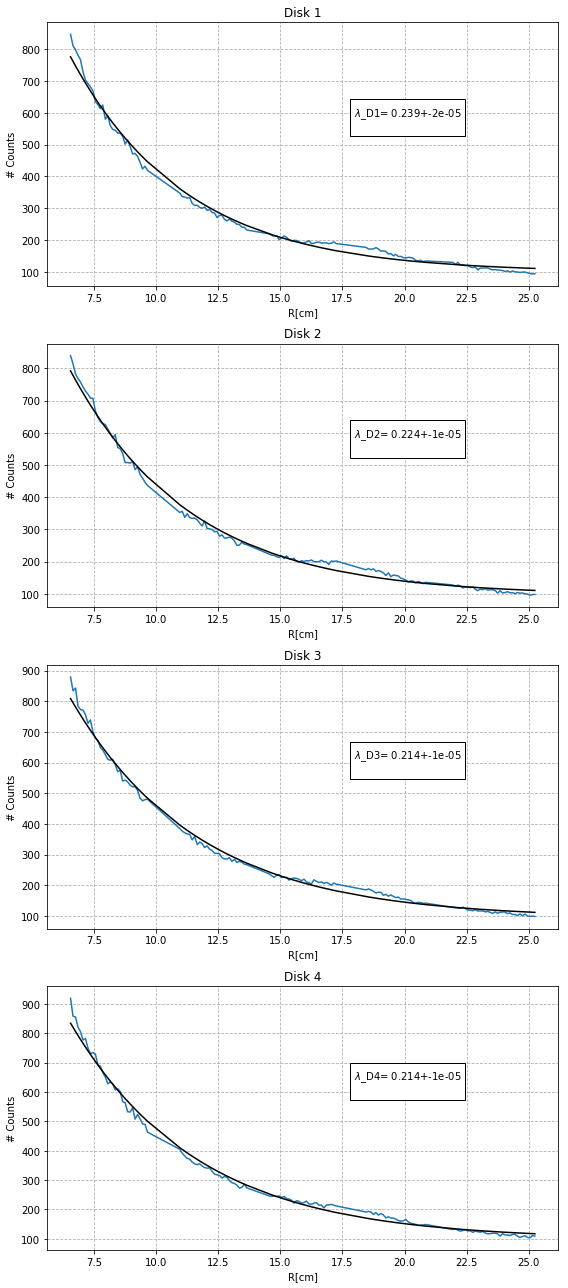

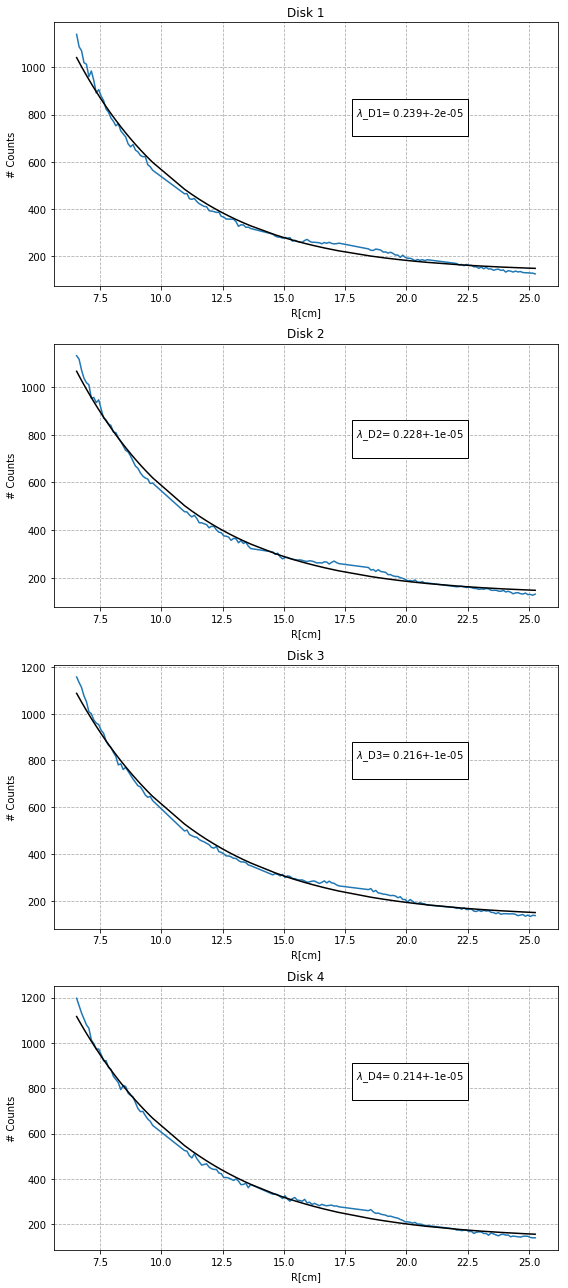

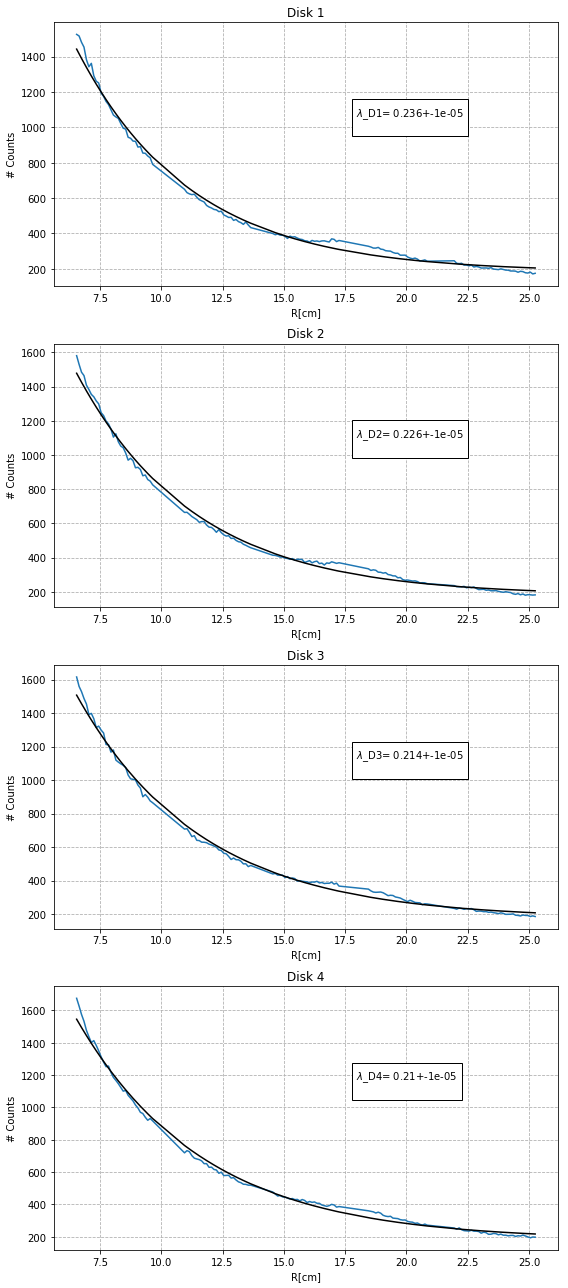

In [306]:
lamb = []
for pu in PU:
    print('-------'+pu+'--------')
    LAMB, D, X, FIT, chiFit = R_decay(pu,funcName='exp2')
    #print('-- FIT --',FIT[0])
    #print('-- COV --',[FIT[1][i][i] for i in np.arange(len(FIT[0]))])
    #LAMB, D, X = R_decay(pu,funcName='exp')
    lamb.append(LAMB)

[2.10344740e-01 3.81142571e+00 2.45723236e+03 2.02929455e+02]
[[ 9.42780503e-06 -4.93208526e+02  2.54791691e+05  1.24679910e-02]
 [-4.93208562e+02  1.11904953e+12 -5.78101210e+14 -7.40397099e+04]
 [ 2.54791709e+05 -5.78101210e+14  2.98647201e+17  3.82489959e+07]
 [ 1.24679910e-02 -7.40396590e+04  3.82489696e+07  2.43889459e+01]]


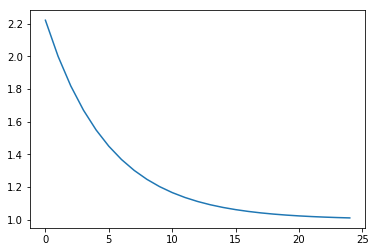

In [139]:
# lamb, x0, N ,y0 = param 
print(FIT[0])
print(FIT[1])
x = np.arange(0,25)
y = exp2(x,*[0.2,1,1,1])
plt.plot(x,y)

In [20]:
ps = [int(pu) for pu in PU]    
ds = {}
for d in Disk[pu]:
    ds[d-1] = [l[d-1] for l in lamb]


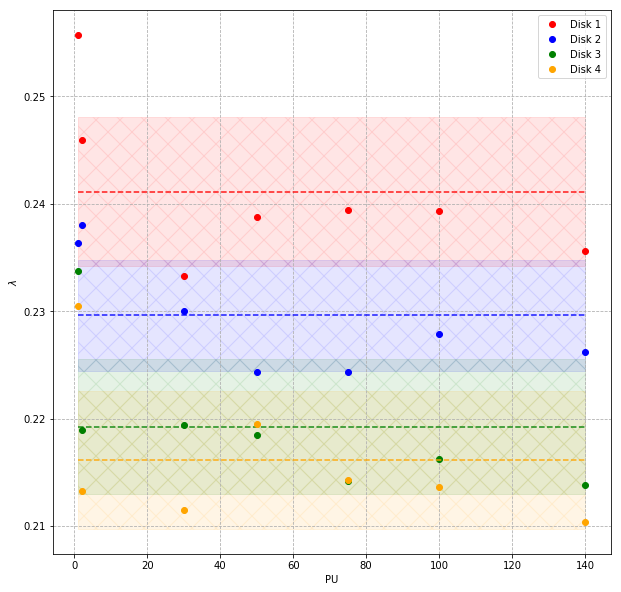

In [79]:
color = ['r','b','g','orange']
n = 0
#n = 1

fig = plt.figure(figsize = (10,10))
L   = np.transpose(lamb)
for i in ds:
    meanL = np.mean(L[i][n:])
    stdL  = np.std(L[i][n:])
    plt.plot(ps[n:],
             L[i][n:],
             'o',
             label='Disk '+str(i+1),
             color = color[i]
            )
    plt.legend()
    
    plt.plot(ps,[meanL for _ in ps],
             linestyle='--',
             color = color[i],
             alpha = 0.9,
            )
    
    plt.fill_between(ps, 
                     [meanL-stdL for _ in ps], 
                     [meanL+stdL for _ in ps], 
                     hatch='X',
                     color=color[i],
                     alpha = 0.1
                     #color='none',
                    )
plt.ylabel(r'$\lambda$')
plt.xlabel('PU')
plt.grid(linestyle='--')

fig.savefig(figPath+'Radial/Lambda.png')

# Number of symLinks per Clusters Distributions

In [319]:
colors = { 
             '1':'r',
             '2':'orange',
            '10':'y',
            '20':'limegreen',
            '30':'g',
            '50':'lightseagreen',
            '75':'aqua',
           '100':'b',
           '140':'blueviolet',
           '175':'purple',
           '200':'k',
         }


In [342]:
def Plotting(dataName, normed=True,cut=True,cutVal=5,doFit=True,funcName='poly1'):
    Mask = {}
    M = []
    

    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        if dataName == "Merge":
            DATA     = getattr(data[pu],'CluMerge')
            Folder   = 'symLink/'
            xlim     = 25
            cutVal   = 5
            if cut: cutLabel = 'Cut'
            else : cutLabel = 'full'
            fileName = 'symLinkPerClusters_'+cutLabel+'.png'
        elif dataName == "Size":
            DATA     = getattr(data[pu],'CluSize')
            Folder   = 'Size/'
            xlim     = 40
            cutVal   = 8
            if cut: cutLabel = 'Cut'
            else : cutLabel = 'full'
            fileName = 'ClusSize_xlim'+str(xlim)+'_'+cutLabel+'.png'
        elif dataName == "Area":
            DATA     = getattr(data[pu],'CluArea')
            Folder   = 'Area/'
            xlim     = 1200
            cutVal   = 10
            fileName = 'ClusArea_xlim'+str(xlim)+'.png'
            
            
        if cut:
            Mask[pu] = DATA <= cutVal
            
            xlim     = cutVal
        else:
            Mask[pu] = np.ones(len(DATA),dtype=np.bool)
            cutLabel = 'full'
            xlim     = 25
            
        h = plt.hist(
                    DATA[Mask[pu]],
                    histtype  = 'step',
                    range     = [1,xlim],
                    bins      = xlim-1,
                    label     = 'PU '+pu,
                    color     = colors[pu],
                    linewidth = 1.3,
                    normed    = normed,
                    )
        if normed:
            M.append(h[0])

    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')            
    if doFit:
        if funcName == 'poly':
            func = poly1
            P0   = [10000,-1]
        elif funcName == 'exp':
            func = exp
            P0   = [0.5,6,  10]
        elif funcName == 'expexp':
            func = expexp
            P0   = [0.5,6,  10,0.1]
        
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')

    ax = plt.gca()
    ax.set_yscale('log')
    plt.ylabel('# Count')    
    plt.xlabel('# symLink per Clusters')    
    plt.legend()
    plt.grid(linestyle='--')

    if normed :
        fig.savefig(figPath+Folder+'normed/'+fileName)
    else:
        fig.savefig(figPath+Folder+fileName)
    plt.show();
    
    return M

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


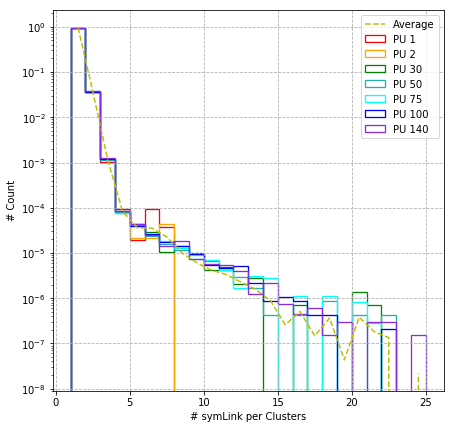

In [349]:
Plotting(dataName='Merge',normed=True, cut=False, cutVal = 5,doFit=False, funcName='poly1')
#Plotting(dataName='Size',normed=True, cut=False, cutVal = 5, doFit=False, funcName='poly1')
#Plotting(dataName='Area',normed=True, cut=False, cutVal = 5, doFit=False, funcName='poly1')

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


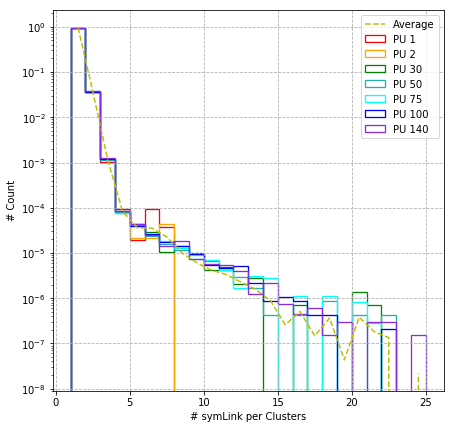

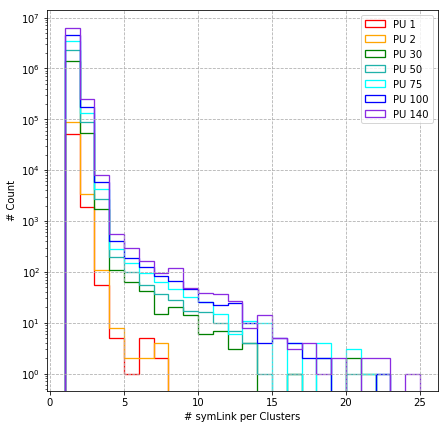

In [329]:
M = []
xlim = 25
for normed in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        h = plt.hist(
                    mergeP[pu],
                    histtype  = 'step',
                    range     = [1,xlim],
                    bins      = xlim-1,
                    label     = 'PU '+pu,
                    color     = colors[pu],
                    linewidth = 1.3,
                    normed    = normed,
                    )
        if normed:
            M.append(h[0])

    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')            
        '''
        func = poly1
        P0 = [10000,-1]
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
        ''';
    
    ax = plt.gca()
    ax.set_yscale('log')
    #ax.set_xscale('log')
    plt.ylabel('# Count')    
    plt.xlabel('# symLink per Clusters')    
    plt.legend()
    plt.grid(linestyle='--')

    if normed :
        fig.savefig(figPath+'symLink/normed/symLinkPerClusters.png')
    else:
        fig.savefig(figPath+'symLink/symLinkPerClusters.png')
    plt.show();


/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


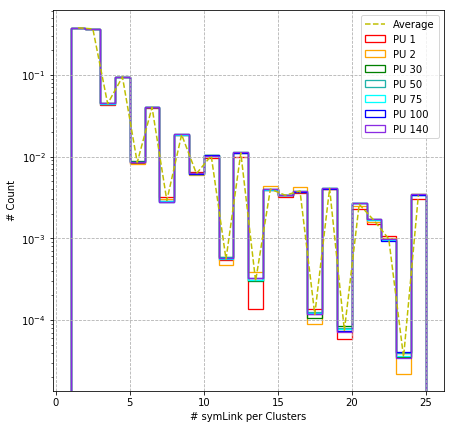

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


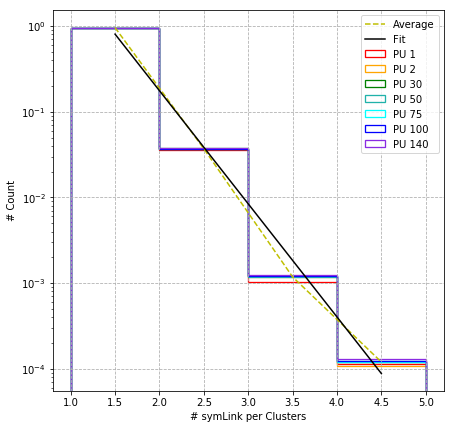

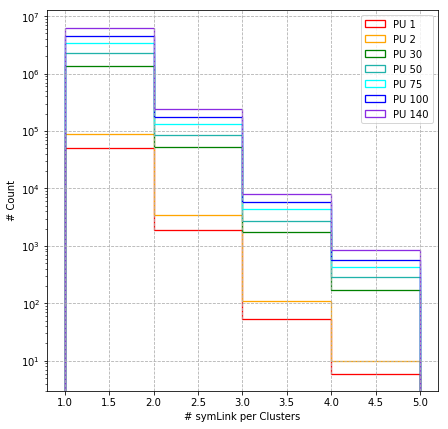

In [82]:


M = []
xlim = 5
for normed in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        h = plt.hist(
                    mergeP[pu][Mask[pu]],
                    histtype  = 'step',
                    range     = [1,xlim],
                    bins      = xlim-1,
                    label     = 'PU '+pu,
                    color     = colors[pu],
                    linewidth = 1.3,
                    normed    = normed,
                    )
        if normed:
            M.append(h[0])

    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')            
    if doFit: 
        func = poly1
        P0 = [10000,-1]
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
        
    
    ax = plt.gca()
    ax.set_yscale('log')
    #ax.set_xscale('log')
    plt.ylabel('# Count')    
    plt.xlabel('# symLink per Clusters')    
    plt.legend()
    plt.grid(linestyle='--')

    if normed :
        fig.savefig(figPath+'/symLink/normed/symLinkPerClusters_fit.png')
    else:
        fig.savefig(figPath+'/symLink/symLinkPerClusters_fit.png')
    plt.show();


# Size plots

In [83]:
Size = {}
for pu in PU:
    Size[pu] = data[pu].CluSize
size = [Size[s] for s in Size]

#xlim = 200
xlim = 8
bins = xlim -1

P0 = [0.05,1,  10,-19]

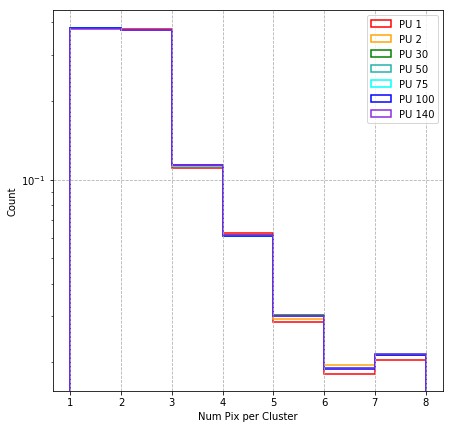

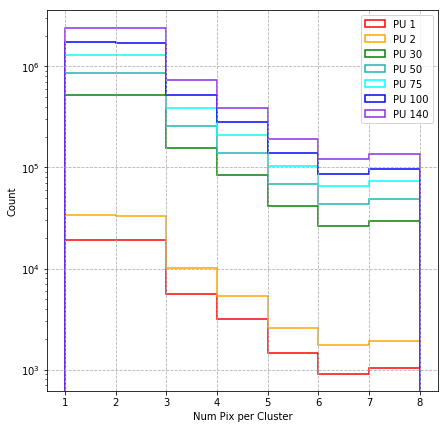

In [84]:
M = []

for density in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        localMask = Mask[pu]
        percent = round(sum(Size[pu][localMask] < xlim)/len(Size[pu][localMask])*100,2)
        h = plt.hist(
                     Size[pu][localMask],
                     histtype  = 'step',
                     range     = [1,xlim],
                     label     = 'PU '+pu,
                     bins      = bins,
                     #normed    = normed,
                     density   = density,
                     color     = colors[pu],
                     linewidth = 1.5,
                    )
        M.append(h[0])
        

    #if normed:
    #    xc = (h[1][:-1]+h[1][1:])/2
    #    ave = sum(M)/len(M)
    #    plt.plot(xc,ave,'y-',label = 'Average')        
    #    
    #    func = exp2 #lamb, x0, N ,y0 
    #    yc = np.log(ave)
    #    mask = np.logical_not(np.isinf(yc))
    #    #fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
    #    #plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
        
    ax = plt.gca()
    #ax.set_xlim([1,xlim])
    ax.set_yscale('log')
    plt.ylabel('Count')
    #plt.xlabel('Size')
    plt.xlabel('Num Pix per Cluster')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show();
    if density :        
        fig.savefig(figPath+'Size/normed/ClusSize_xlim'+str(xlim)+'P'+str(percent)+'.png')
        fig.savefig(figPath+'Size/normed/ClusSize_xlim'+str(xlim)+'P'+str(percent)+'.pdf')
    else:
        fig.savefig(figPath+'Size/ClusSize_xlim'+str(xlim)+'.png')
        fig.savefig(figPath+'Size/ClusSize_xlim'+str(xlim)+'.pdf')

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


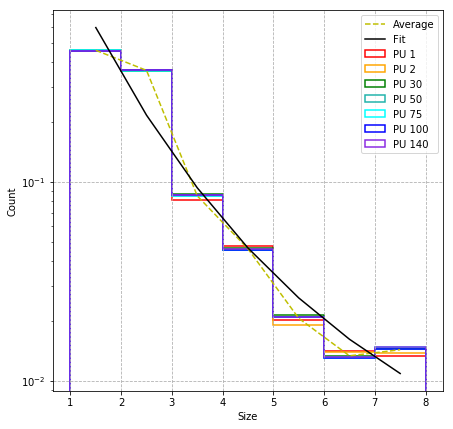

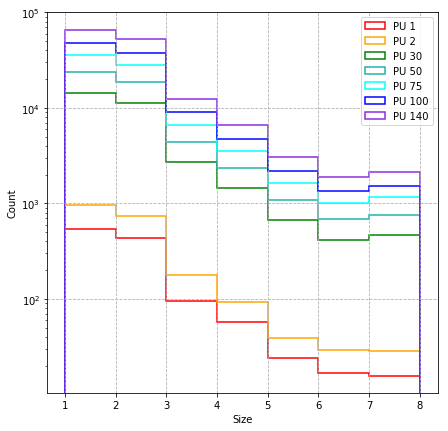

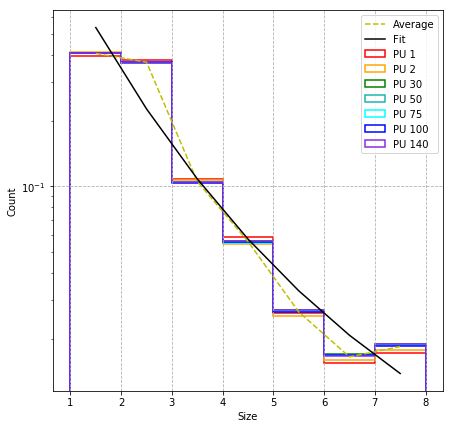

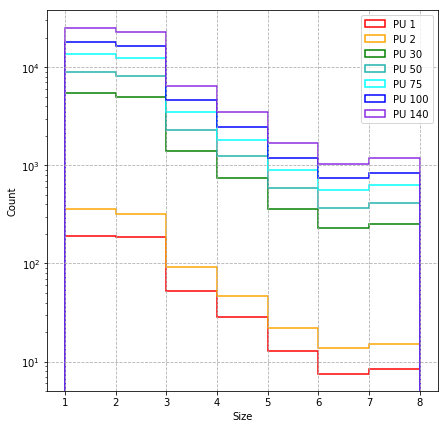

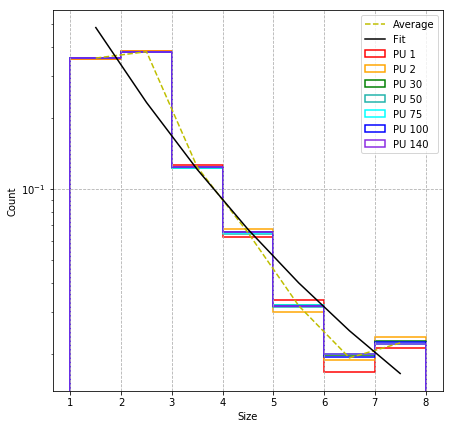

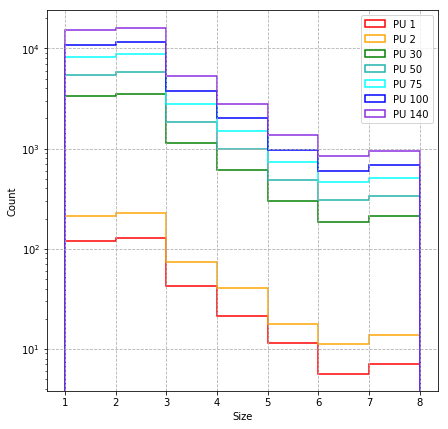

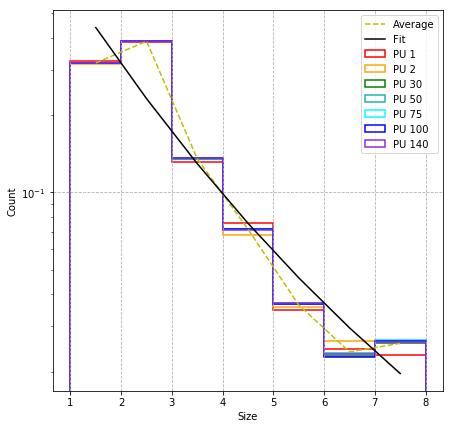

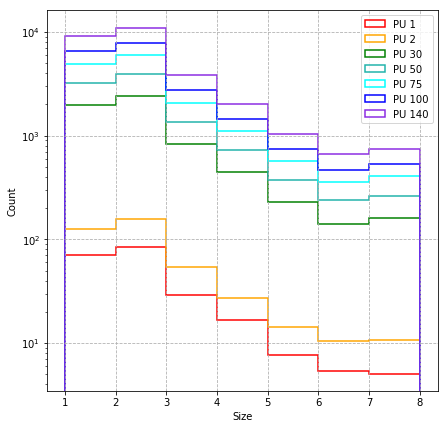

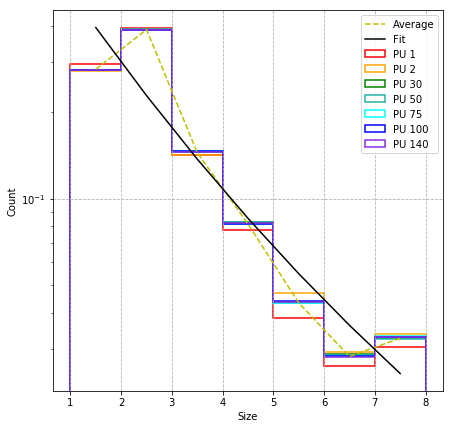

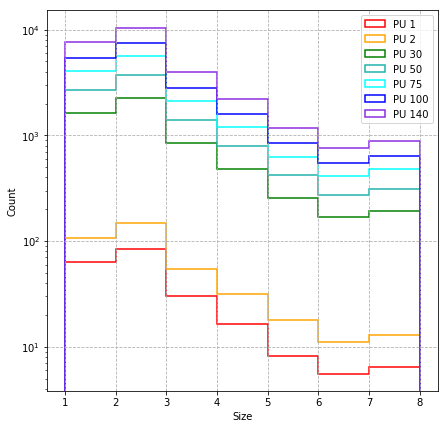

In [85]:
for ring in [1,2,3,4,5]:
    
    M = []
    for normed in [True,False]:
        fig = plt.figure(figsize=(7,7))
        for pu in PU:
            localMask = np.logical_and(Mask[pu],Ring[pu][ring])
            percent = round(sum(Size[pu][localMask] < xlim)/len(Size[pu][localMask])*100,2)
            h = plt.hist(
                         Size[pu][localMask],
                         weights = [1/NRing[ring] for _ in Size[pu][localMask]],
                         histtype  = 'step',
                         range     = [1,xlim],
                         label     = 'PU '+pu,
                         bins      = bins,
                         normed    = normed,
                         color     = colors[pu],
                         linewidth = 1.5,
                        )
            M.append(h[0])

        if normed:
            xc = (h[1][:-1]+h[1][1:])/2
            ave = sum(M)/len(M)
            plt.plot(xc,ave,'y--',label = 'Average')        

            func = exp2 #lamb, x0, N ,y0 
            yc = np.log(ave)
            mask = np.logical_not(np.isinf(yc))
            fit = curve_fit(func,xc[mask],yc[mask],p0=[0.05,1,  0,-19])
            plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')

        ax = plt.gca()
        ax.set_yscale('log')
        plt.ylabel('Count')
        plt.xlabel('Size')
        plt.legend()
        plt.grid(linestyle='--')
        plt.show();
        if normed :
            fig.savefig(figPath+'Size/normed/ClusSize_Ring'+str(ring)+'_xlim'+str(xlim)+'P'+str(percent)+'.png')
        else:
            fig.savefig(figPath+'Size/ClusSize_Ring'+str(ring)+'_xlim'+str(xlim)+'.png')

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


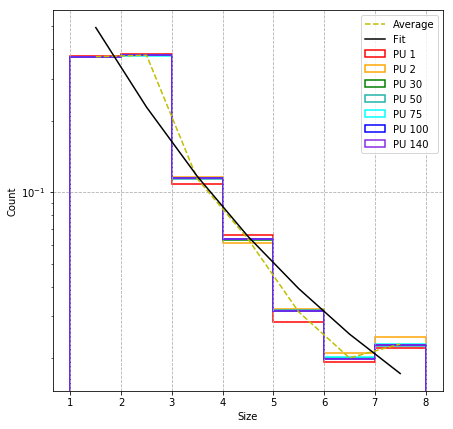

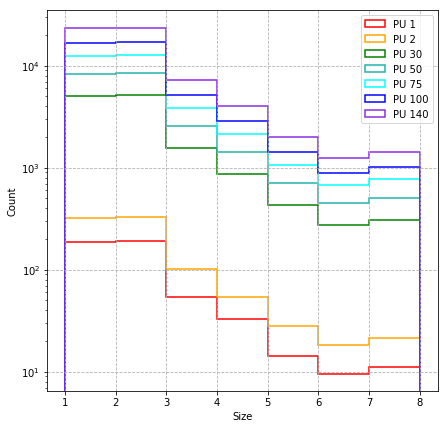

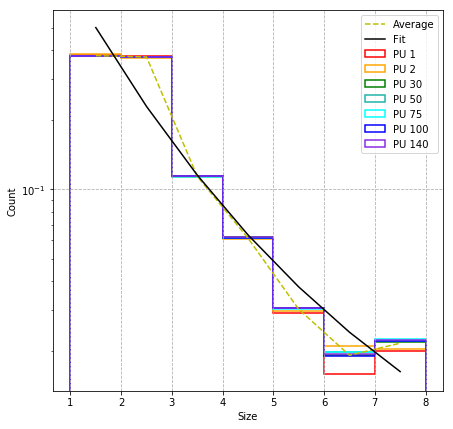

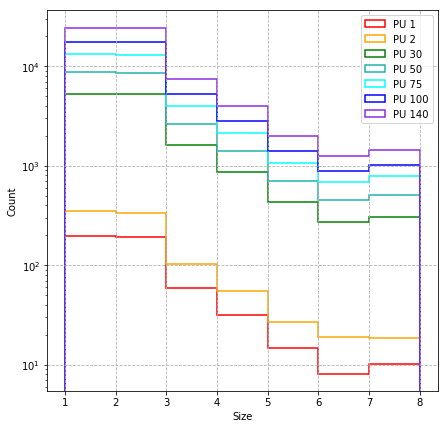

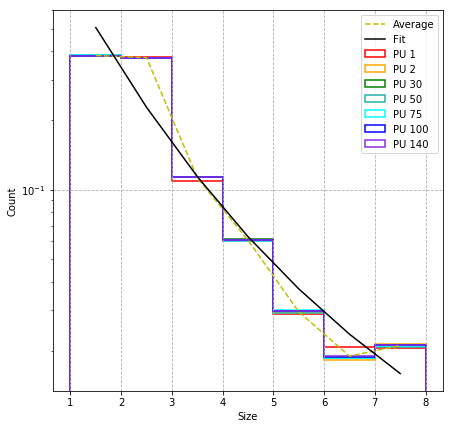

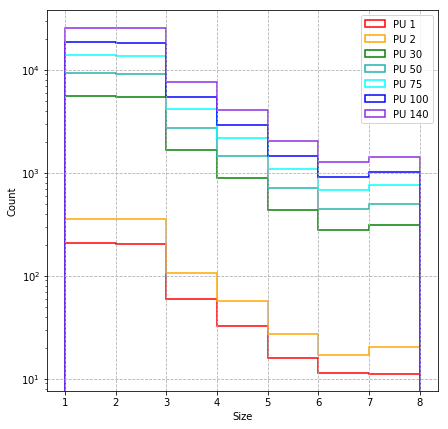

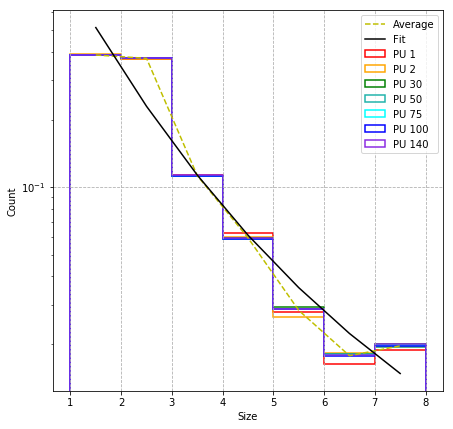

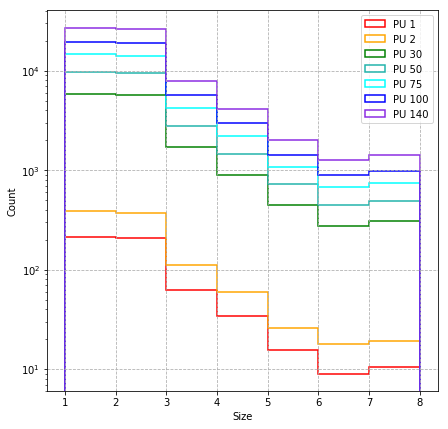

In [86]:
for disk in [1,2,3,4]:
    
    M = []
    for normed in [True,False]:
        fig = plt.figure(figsize=(7,7))
        for pu in PU:
            localMask = np.logical_and(Mask[pu],Disk[pu][disk])
            percent = round(sum(Size[pu][localMask] < xlim)/len(Size[pu][localMask])*100,2)
            h = plt.hist(
                         Size[pu][localMask],
                         weights = [1/NRing[ring] for _ in Size[pu][localMask]],
                         histtype  = 'step',
                         range     = [1,xlim],
                         label     = 'PU '+pu,
                         bins      = bins,
                         normed    = normed,
                         color     = colors[pu],
                         linewidth = 1.5,
                        )
            M.append(h[0])

        if normed:
            xc = (h[1][:-1]+h[1][1:])/2
            ave = sum(M)/len(M)
            plt.plot(xc,ave,'y--',label = 'Average')        

            func = exp2 #lamb, x0, N ,y0 
            yc = np.log(ave)
            mask = np.logical_not(np.isinf(yc))
            fit = curve_fit(func,xc[mask],yc[mask],p0=[0.05,1,  0,-19])
            plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')

        ax = plt.gca()
        ax.set_yscale('log')
        plt.ylabel('Count')
        plt.xlabel('Size')
        plt.legend()
        plt.grid(linestyle='--')
        plt.show();
        if normed :
            fig.savefig(figPath+'Size/normed/ClusSize_Disk'+str(disk)+'_xlim'+str(xlim)+'P'+str(percent)+'.png')
        else:
            fig.savefig(figPath+'Size/ClusSize_Disk'+str(disk)+'_xlim'+str(xlim)+'P'+str(percent)+'.png')

# Area plots

In [87]:
Area = {}
for pu in PU:
    Area[pu] = (data[pu].CluArea)
area = [Area[a] for a in Area]

xlim = 10
#bins = int((xlim-1)/2)
#bins = xlim-1
#bins = xlim
bins = [i+0.5 for i in range(xlim)]


/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


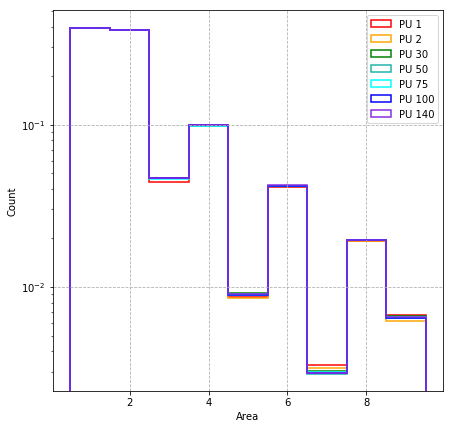

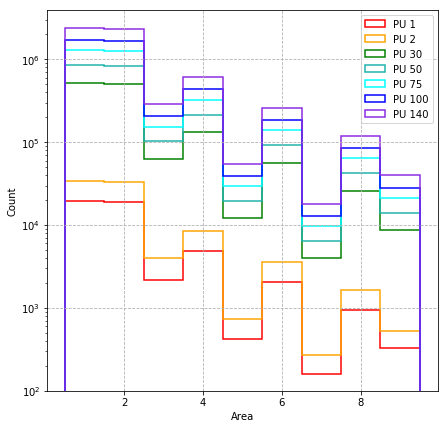

In [88]:
M = []


for normed,density in zip([True,False],[True,False]):
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        localMask = Mask[pu]
        h = plt.hist(
                     Area[pu][localMask],
                     histtype  = 'step',
                     range     = [1,xlim],
                     label     = 'PU '+pu,
                     bins      = bins,
                     normed    = normed,
                     color     = colors[pu],
                     linewidth = 1.5,
                    )
        M.append(h[0])
    '''
    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')
        
        #func = exp2 #lamb, x0, N ,y0 
        #yc = np.log(ave)
        #mask = np.logical_not(np.isinf(yc))
        #fit = curve_fit(func,xc[mask],yc[mask],p0=[0.05,1,  0,-19])
        #plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
    ''';
    
    ax = plt.gca()
    ax.set_yscale('log')
    plt.ylabel('Count')
    plt.xlabel('Area')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show();
    if normed or density:
        fig.savefig(figPath+'Area/normed/ClusArea_xlim'+str(xlim)+'_normed.png')
        fig.savefig(figPath+'Area/normed/ClusArea_xlim'+str(xlim)+'_normed.pdf')
    else:
        fig.savefig(figPath+'Area/ClusArea_xlim'+str(xlim)+'.png')
        fig.savefig(figPath+'Area/ClusArea_xlim'+str(xlim)+'.pdf')

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


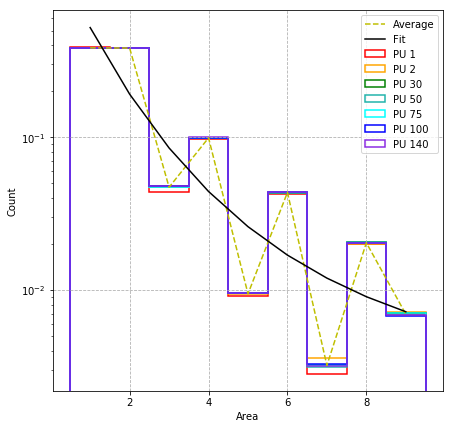

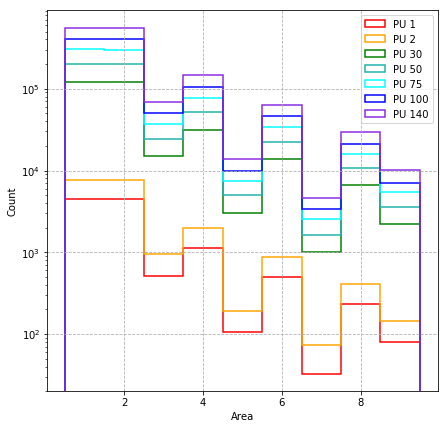

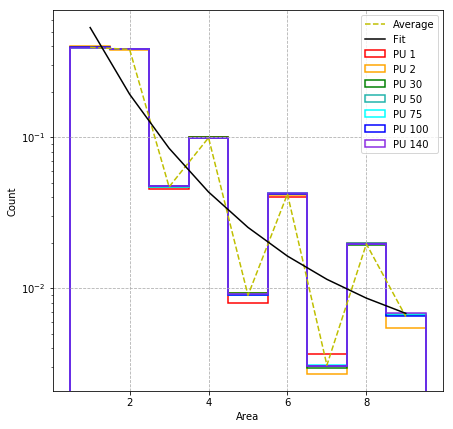

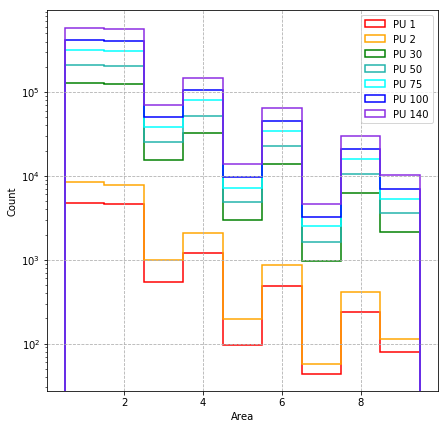

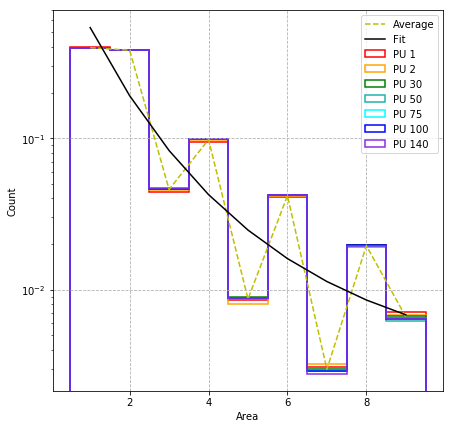

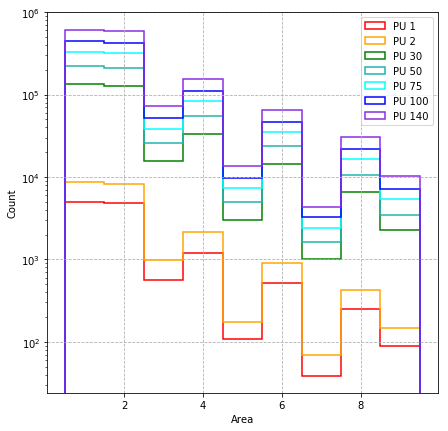

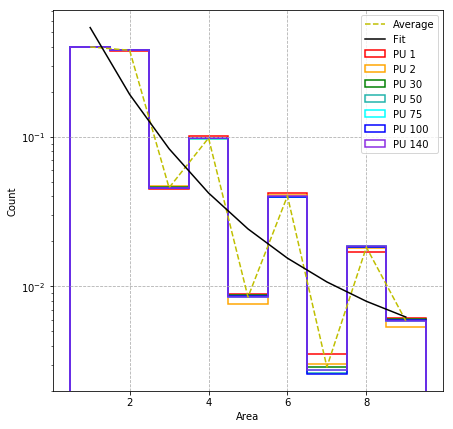

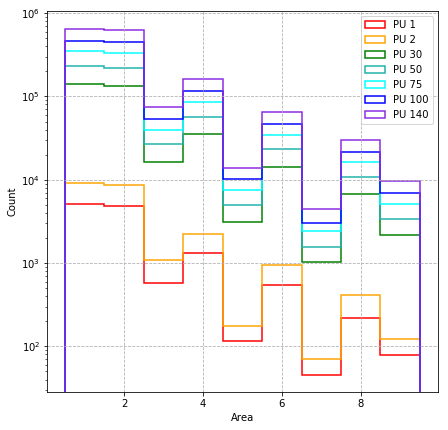

In [90]:

for disk in [1,2,3,4]:
    
    M = []
    for normed in [True,False]:
        fig = plt.figure(figsize=(7,7))
        for pu in PU:
            localMask = np.logical_and(Mask[pu],Disk[pu][disk])
            h = plt.hist(
                         Area[pu][localMask],
                         histtype  = 'step',
                         range     = [1,xlim],
                         label     = 'PU '+pu,
                         bins      = bins,
                         normed    = normed,
                         color     = colors[pu],
                         linewidth = 1.5,
                        )
            M.append(h[0])
        if normed:
            xc = (h[1][:-1]+h[1][1:])/2
            ave = sum(M)/len(M)
            plt.plot(xc,ave,'y--',label = 'Average')

            func = exp2 #lamb, x0, N ,y0 
            yc = np.log(ave)
            mask = np.logical_not(np.isinf(yc))
            fit = curve_fit(func,xc[mask],yc[mask],p0=[0.05,1,  0,-19])
            plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')

        ax = plt.gca()
        ax.set_yscale('log')
        plt.ylabel('Count')
        plt.xlabel('Area')
        plt.legend()
        plt.grid(linestyle='--')
        plt.show();
        if normed :
            fig.savefig(figPath+'Area/normed/ClusArea_Disk'+str(disk)+'_xlim'+str(xlim)+'.png')
        else:
            fig.savefig(figPath+'Area/ClusArea_Disk'+str(disk)+'_xlim'+str(xlim)+'.png')

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


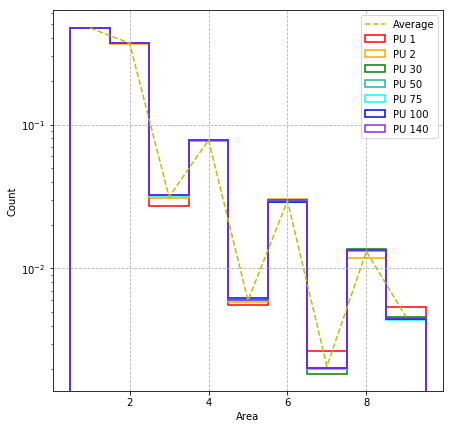

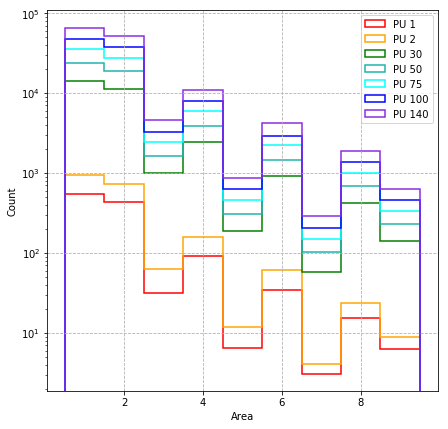

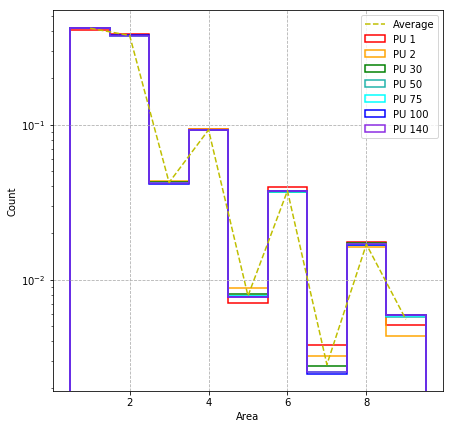

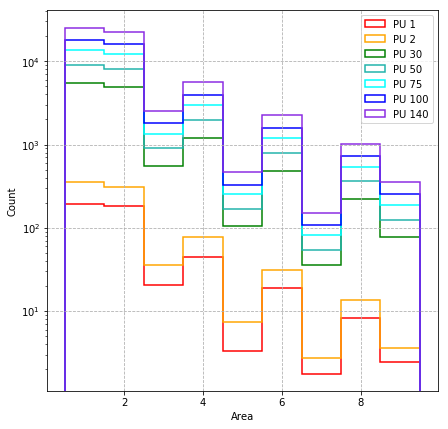

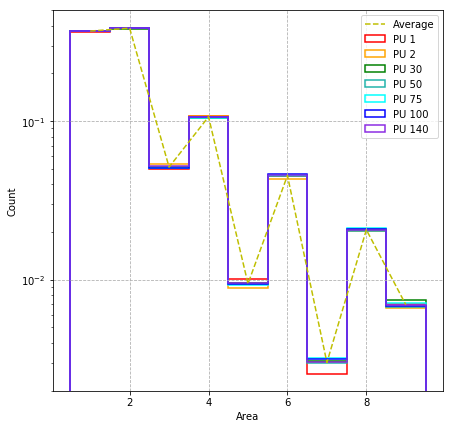

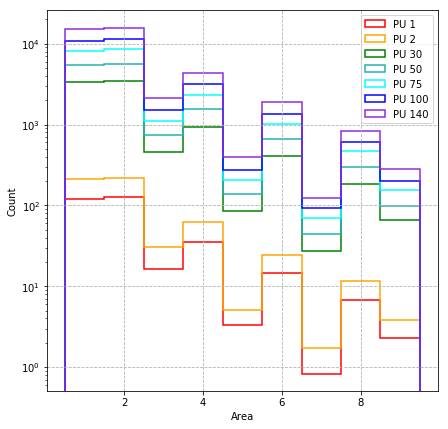

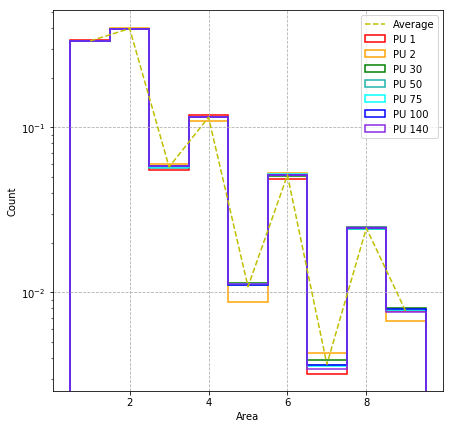

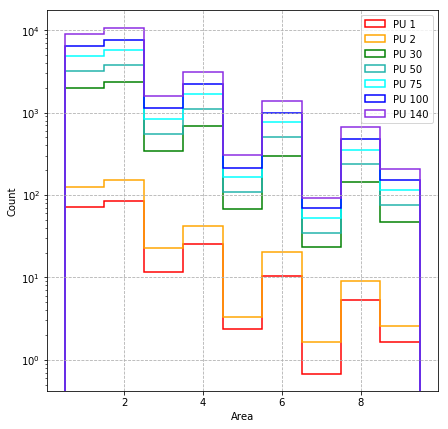

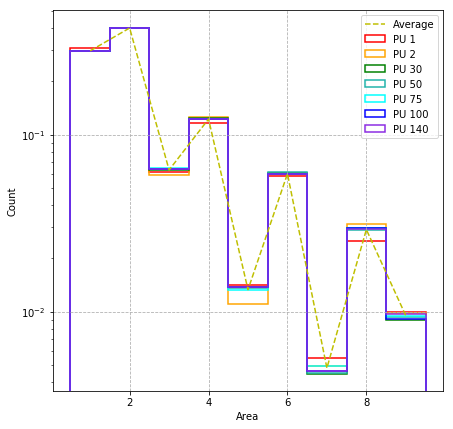

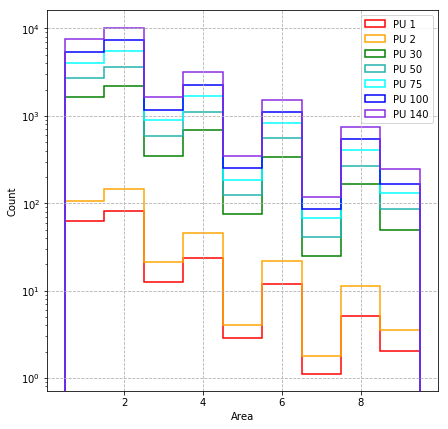

In [91]:

for ring in [1,2,3,4,5]:
    M = []
    for normed in [True,False]:
        fig = plt.figure(figsize=(7,7))
        for pu in PU:
            localMask = np.logical_and(Mask[pu],Ring[pu][ring])
            h = plt.hist(
                         Area[pu][localMask],
                         weights = [1/NRing[ring] for _ in Area[pu][localMask]],
                         histtype  = 'step',
                         range     = [0,xlim],
                         label     = 'PU '+pu,
                         bins      = bins,
                         normed    = normed,
                         color     = colors[pu],
                         linewidth = 1.5,
                        )
            M.append(h[0])
        if normed:
            xc = (h[1][:-1]+h[1][1:])/2
            ave = sum(M)/len(M)
            plt.plot(xc,ave,'y--',label = 'Average')

            #func = exp2 #lamb, x0, N ,y0 
            #yc = np.log(ave)
            #mask = np.logical_not(np.isinf(yc))
            #fit = curve_fit(func,xc[mask],yc[mask],p0=[0.05,1,  0,-19])
            #plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')

        ax = plt.gca()
        ax.set_yscale('log')
        plt.ylabel('Count')
        plt.xlabel('Area')
        plt.legend()
        plt.grid(linestyle='--')
        plt.show();
        if normed :
            fig.savefig(figPath+'Area/normed/ClusArea_Ring'+str(ring)+'_xlim'+str(xlim)+'.png')
        else:
            fig.savefig(figPath+'Area/ClusArea_Ring'+str(ring)+'_xlim'+str(xlim)+'.png')

# Z dependance

In [92]:
Z = {}
for pu in PU:
    Z[pu] = (data[pu].CluZ)

xlim = 300
#bins = int((xlim-1)/2)
bins = xlim-1

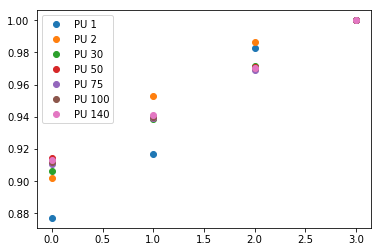

In [93]:
ring = 1
plt.figure()
zd={}
for pu in PU:
    zd[pu] = []
    localMask = np.logical_and(Mask[pu],Ring[pu][ring])

    for d in Disk[pu]:
        #if d in [1,2,3]: continue
        localMask = np.logical_and(Mask[pu],Ring[pu][ring])
        localMask = np.logical_and(localMask,Disk[pu][d])
        zd[pu].append(len(Z[pu][localMask]))
    zd[pu] = np.array(zd[pu])
    plt.plot(zd[pu]/max(zd[pu]),'o',label='PU '+pu)
ax = plt.gca()
#ax.set_yscale('log')
plt.legend()

In [94]:
#mask_nonOverlap

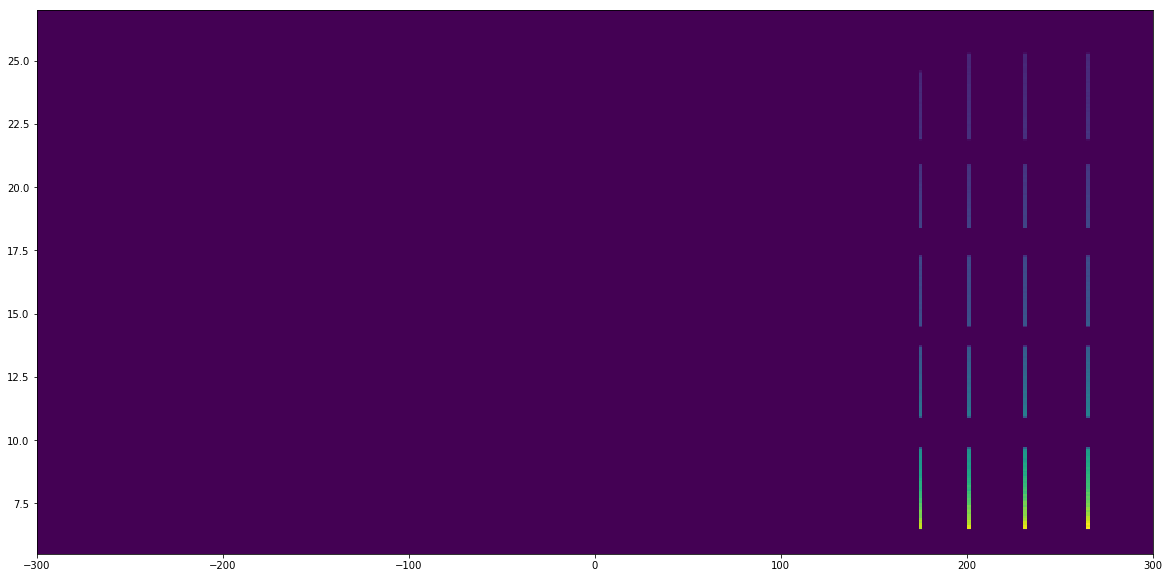

In [107]:
pu = '140'
mask = mask_nonOverlap[pu]
#mask = np.ones(len(Disk[pu][1]),dtype=np.bool)
#mask = Disk[pu][4]
mask = np.logical_and(mask,thetaP[pu] < 8*(np.pi/180))
#mask = np.logical_and(thetaP[pu] < 5*(np.pi/180), thetaP[pu] > 0)
fig = plt.figure(figsize=(20,10))
#plt.hist2d(zP[pu][localMask],rP[pu][localMask],
plt.hist2d(zP[pu][mask],rP[pu][mask],
           weights = wei[pu][mask],
         bins = 300,
        range = [[-300,300],[5.5,27]]
        );

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


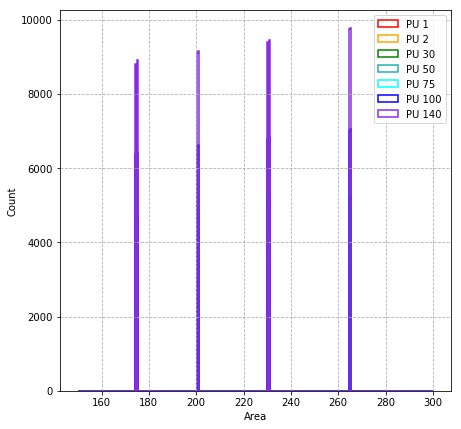

In [108]:
ring = 1

M = []
normed = False
    
fig = plt.figure(figsize=(7,7))
for pu in PU:
    localMask = np.logical_and(Mask[pu],Ring[pu][ring])
    h = plt.hist(
                 Z[pu][localMask],
                 weights = wei[pu][localMask],
                 histtype  = 'step',
                 range     = [150,xlim],
                 label     = 'PU '+pu,
                 bins      = bins,
                 normed    = normed,
                 color     = colors[pu],
                 linewidth = 1.5,
                )
'''
    M.append(h[0])
if normed:
    xc = (h[1][:-1]+h[1][1:])/2
    ave = sum(M)/len(M)
    plt.plot(xc,ave,'y--',label = 'Average')

    #func = exp2 #lamb, x0, N ,y0 
    #yc = np.log(ave)
    #mask = np.logical_not(np.isinf(yc))
    #fit = curve_fit(func,xc[mask],yc[mask],p0=[0.05,1,  0,-19])
    #plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
''';

ax = plt.gca()
#ax.set_yscale('log')
plt.ylabel('Count')
plt.xlabel('Area')
plt.legend()
plt.grid(linestyle='--')
plt.show();
if normed :
    fig.savefig(figPath+'Z/normed/ClusZ_Ring'+str(ring)+'_xlim'+str(xlim)+'.png')
else:
    fig.savefig(figPath+'Z/ClusZ_Ring'+str(ring)+'_xlim'+str(xlim)+'.png')

In [109]:
np.sum(Ring[pu][ring])

1485497

# Theta dependance

In [110]:
Theta = {}
for pu in PU:
    Theta[pu] = (data[pu].CluTheta)

xlim = 300
#bins = int((xlim-1)/2)
bins = xlim-1

In [111]:
wei = {}    
for pu in PU:
    print('--------',pu,'---------')
    localMask = Mask[pu]
    wei[pu] = np.ones(len(Theta[pu]))
    
    for ring in Ring[pu]:
        wei[pu][Ring[pu][ring]] = np.ones(np.sum(Ring[pu][ring]))*1/NRing[ring]

-------- 1 ---------
-------- 2 ---------
-------- 30 ---------
-------- 50 ---------
-------- 75 ---------
-------- 100 ---------
-------- 140 ---------


/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


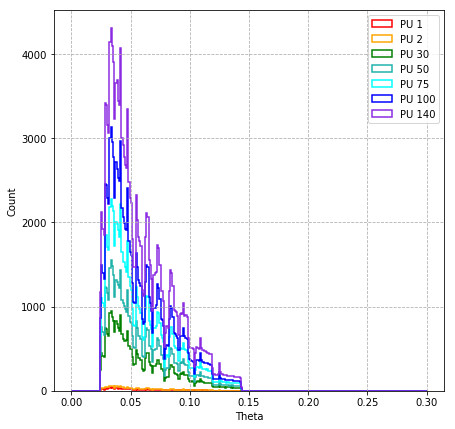

In [112]:
ring = 1

M = []
normed = False


fig = plt.figure(figsize=(7,7))
for pu in PU:
    localMask = np.logical_and(Mask[pu],mask_nonOverlap[pu])
    #localMask = np.logical_and(Mask[pu],Ring[pu][ring])
    

    
    h = plt.hist(
                 Theta[pu][localMask],
                 weights = wei[pu][localMask],#[1/NRing[ring] for _ in Z[pu][localMask]],
                 histtype  = 'step',
                 range     = [0,0.3],#[-np.pi,np.pi],
                 label     = 'PU '+pu,
                 bins      = bins,
                 normed    = normed,
                 color     = colors[pu],
                 linewidth = 1.5,
                )
'''
    M.append(h[0])
if normed:
    xc = (h[1][:-1]+h[1][1:])/2
    ave = sum(M)/len(M)
    plt.plot(xc,ave,'y--',label = 'Average')

    #func = exp2 #lamb, x0, N ,y0 
    #yc = np.log(ave)
    #mask = np.logical_not(np.isinf(yc))
    #fit = curve_fit(func,xc[mask],yc[mask],p0=[0.05,1,  0,-19])
    #plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
''';

ax = plt.gca()
#ax.set_yscale('log')
plt.ylabel('Count')
plt.xlabel('Theta')
plt.legend()
plt.grid(linestyle='--')
plt.show();
if normed :
    fig.savefig(figPath+'Theta/normed/ClusTheta.png')
else:
    fig.savefig(figPath+'Theta/ClusTheta.png')

In [113]:
print(
len(Theta['140'][Mask['140']]),
len(wei)
)

6594016 7
